In [5]:
from pylab import *
import matplotlib.pyplot as plt
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gim
import pandas as pd
from itertools import product
import csv
from itertools import chain, combinations
import seaborn as sns

plt.ioff() 

** pyAgrum** For better visualizations, please install matplotlib-inline.


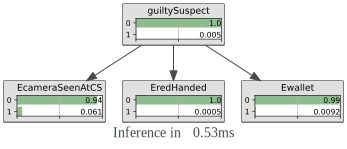

In [6]:
bn_f = 'bn200.net'
bn_f = 'finalBNevIdiom.net'
bn=gum.loadBN(bn_f)
gnb.showInference(bn)
gim.exportInference(bn, "bnstructureP12.png")

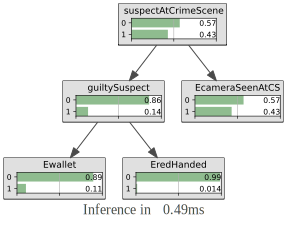

In [7]:
bn_f = 'finalOpportunity.net'
bn=gum.loadBN(bn_f)
gnb.showInference(bn)
gim.exportInference(bn, "bnstructureP3.png")

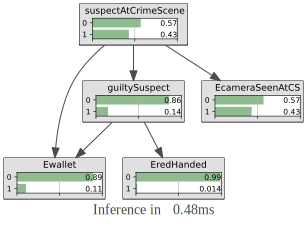

In [8]:
bn_f = 'finalOpportunityExtraArc.net'
bn=gum.loadBN(bn_f)
gnb.showInference(bn)


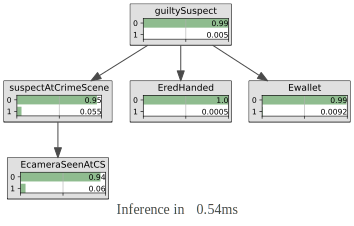

In [9]:
bn_f = 'reasonBN.net'
bn=gum.loadBN(bn_f)
gnb.showInference(bn)
gim.exportInference(bn, "bnstructureP4.png")

In [10]:
#params= pd.read_csv("paramsNew.csv")


In [106]:
def calculate_posteriors(params, prior_method, evidence_d, true_prior):
    print(prior_method)
    

    # load in dataset
    #params= pd.read_csv("paramsNew.csv")
    params = params.loc[params["seen"] != 200] # only get with IDs
    RUN_NUM = 1000 #(len(params)/3) 

    params['Eseen'] = params['Eseen.Eseen']
    params["Eseen"] = params["Eseen"].astype('Int64')
    
    params = params.reset_index()
    dict_outcomes = {"guilty":[],"innocentClose": [], "innocentRandom": []}
    
    
    # load in bayesian network
    

    if prior_method == "OPPORTUNITY":
        bn=gum.loadBN('finalOpportunity.net')
        
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
    
    elif prior_method == "REASON":
        bn=gum.loadBN('reasonBN.net')
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
        
    elif prior_method == "EXTRAARC":
        bn=gum.loadBN('finalOpportunityExtraArc.net')
        
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
        
        g1 = evidence_d["p_Ewallet_given_guilty_CS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1, "guiltySuspect":1}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_notguilty_CS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1, "guiltySuspect":0}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_guilty_notCS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0, "guiltySuspect":1}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_notguilty_notCS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0, "guiltySuspect":0}] = [1 - g1, g1]
    

    else:
        bn=gum.loadBN('finalBNevIdiom.net')
        
        g1 = evidence_d["p_Eseen_given_guilty"]
        g0 = evidence_d['p_Eseen_given_notguilty']
        
        bn.cpt("EcameraSeenAtCS")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
        bn.cpt("EcameraSeenAtCS")[{"guiltySuspect":0}] = [1-g0, g0]
    

    
    if prior_method != "EXTRAARC":
        g1 = evidence_d["p_Ewallet_given_guilty"]
        g0 = evidence_d['p_Ewallet_given_notguilty']
    
        bn.cpt("Ewallet")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
        bn.cpt("Ewallet")[{"guiltySuspect":0}] = [1-g0, g0]
 
 
    g1 = evidence_d["p_redhanded_given_guilty"]
    g0 = evidence_d['p_redhanded_given_notguilty']
 
    bn.cpt("EredHanded")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
    bn.cpt("EredHanded")[{"guiltySuspect":0}] = [1-g0, g0]
    
    
    
    if true_prior == 1:
        opp_column = "opp"
        guilt_column = "guilty"
    elif true_prior == 2:
        opp_column = "oppSeen"
        guilt_column = "guiltySeen"
    elif true_prior == 3:
        opp_column = "oppSmalln"
        guilt_column = "guiltySmalln"
    elif true_prior == 4:
        opp_column = "oppSeenSmalln"
        guilt_column = "guiltySeenSmalln"
        
    
    for index, row in params.iterrows():
        #print(str(row["type"]))
        if str(row["type"]) == "nan":
            print("this row is full of nans")
            continue
        
        if prior_method == "OPPORTUNITY" or prior_method == "EXTRAARC":
            P_oppPrior = row[opp_column]
            P_guilty = row[guilt_column]
            bn.cpt("suspectAtCrimeScene")[{}] = [1-P_oppPrior, P_oppPrior]
            bn.cpt("guiltySuspect")[{"suspectAtCrimeScene":1}] = [1-P_guilty, P_guilty]
            bn.cpt("guiltySuspect")[{"suspectAtCrimeScene":0}] = [1, 0]
            
            #print(f"n = {row['getsmalln']}")
            #print(f"N = {row['n']}")
        elif prior_method == "REASON":
            P_guilty = (row['getsmalln']-1)/200 # there are x out of 200 people at CS

            bn.cpt("guiltySuspect")[{}] = [1-0.01, 0.01]
            
            bn.cpt("suspectAtCrimeScene")[{"guiltySuspect":1}] = [0, 1]
            bn.cpt("suspectAtCrimeScene")[{"guiltySuspect":0}] = [1-P_guilty,P_guilty]
            

        elif prior_method == "WORLD":
            bn.cpt("guiltySuspect")[{}]= [1-0.005, 0.005]
        elif prior_method == "LEGAL":
            bn.cpt("guiltySuspect")[{}] = [1-0.01, 0.01]
        else:
            print("prior method not implemented")
            exit()
            
       
        #print(row['E'], row['heterdaad'])
        
        ev_dict = {"Ewallet":int(row['E']), "EredHanded":int(row['heterdaad'])}


        if row['Eseen'] == 1 or row['Eseen'] == 0:
            ev_dict["EcameraSeenAtCS"]=row['Eseen']
            
        #print(row["type"])
        
                   
        try:
            s = gum.getPosterior(bn, evs=ev_dict, target="guiltySuspect")
        except Exception:
            print("exeption")
            s = [1, 0]
        
        if ev_dict["Ewallet"] == 1:
            if "EcameraSeenAtCS" in ev_dict.keys():
                if ev_dict["EcameraSeenAtCS"] == 1:
                    if row["type"] != "guilty":
                        print(ev_dict)
                        print("wal 1 cam 1")

                        print(row["runNumber"], row["type"], row["getsmalln"], row["n"])
                        print(s[1])
            
        '''if row["type"] != "guilty" and row["E"] == 1:
            print(row["runNumber"], row["type"], ev_dict, s[1], row["getsmalln"], row["n"])
        if row["type"] != "guilty" and row["Eseen"] == 1:
            print("\t", row["runNumber"], row["type"], ev_dict, s[1], row["getsmalln"], row["n"])
        '''
            
        if row["type"] != "guilty" and s[1] >= 0.95:
            print("\t\t", row["runNumber"], row["getsmalln"], row["n"])
        
        #print(bn.cpt("suspectAtCrimeScene"))
        #print(bn.cpt("guiltySuspect"))
        
        #gnb.showInference(bn, evs=ev_dict)
        
        key = row['type']
        x = dict_outcomes[key]
        x.append(s[1])
        dict_outcomes[key] = x

    for type_suspect in ["guilty", "innocentClose", "innocentRandom"]:
        print(RUN_NUM, type_suspect, len(dict_outcomes[type_suspect]))
        while len(dict_outcomes[type_suspect]) < RUN_NUM:
            dict_outcomes[type_suspect].append(0)
        print(len(dict_outcomes[type_suspect]))
    
    n = pd.DataFrame.from_dict(dict_outcomes)
    return n

def ROC_curve(n, innocentType, RUN_NUM, t_type):
    print(f"guilty vs {innocentType}")
    TPR_collected = []
    FPR_collected = []
    
    if t_type == 2:
        range_s = 85
        range_e = 100
    if t_type == 1:
        range_s = 0
        range_e = 100
        
    for t in range(range_s, range_e):
        ct = n.copy()
        t = t/100
        ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
        ct[innocentType] = [1 if x >= t else 0 for x in ct[innocentType]]
        tp =  ct['guilty'].sum()
        fn = len(ct['guilty']) - tp
        fp =  ct[innocentType].sum()
        tn =  len(ct[innocentType])-fp
        #if t > 0.94:
        print(f"{t} & {tp/RUN_NUM} & {fp/RUN_NUM} & {tp/(fp+0.000001)}\\\\") # divide by total
        tpr = tp/(tp + fn) # correctly predicted positives vs all actually positives 
        fpr = fp/(fp + tn) # incorrectly predicted positives vs all actually negatives
        TPR_collected.append(tpr)
        FPR_collected.append(fpr)
    #print(FPR_collected, TPR_collected)
    return FPR_collected, TPR_collected

def calculate_value_counts(d, key, val):
    r = 0
    try:
        r = d[key].value_counts()[val]
    except KeyError:
        return 0
    else:
        return r
    

def calculate_mcc(innocent_type, n):
    #print(inspect.stack()[1].function)
    # threshold is set at 0.95
    ct = n.copy()
    t = 0.95
    ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
    ct[innocent_type] = [1 if x >= t else 0 for x in ct[innocent_type]]
    
    tp = calculate_value_counts(ct, 'guilty', 1)
    fn = calculate_value_counts(ct, 'guilty', 0)
    fp = calculate_value_counts(ct, innocent_type, 1)
    tn = calculate_value_counts(ct, innocent_type, 0)
    

    if inspect.stack()[1].function == "run_analysis" or inspect.stack()[1].function == "run_mcc_analysis":
        print("correctly classified as guilty (tp): ", tp)
        print("incorrectly classified as innocent (fn): ",fn)
        print("incorrectly classified as guilty (fp): ", fp)
        print("correctly classfied as innocent (tn): ", tn)
    
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    if denom == 0:
        denom = 1
    
    mcc = ((tp*tn)-(fp*fn))/sqrt(denom)
    print(f"mcc with threshold as {t} for {innocent_type} is {mcc}")
    return mcc
    

def plotROCS(fpr, tpr, inType, c, pt):
    plt.title(f"ROC curve guilty vs {inType}")
    plt.plot(fpr, tpr, "-", color=c)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.savefig(f"ROCClose{pt}{inType}.png")
    plt.show()

def plotROCStogether(prior_method, iCROC1, iCROC2, iRROC1, iRROC2):
    plt.title(f"ROC curves {prior_method}")
    
    (c, fpr_c, tpr_c) = iCROC1
    
    plt.plot(fpr_c, tpr_c, "-", color="red", label="negative case = innocent bystander")
    
    (r, fpr_r, tpr_r) = iRROC1
    plt.plot(fpr_r, tpr_r, ":", color="blue", label= "negative case = innocent random")
    
    (c, fpr_c, tpr_c) = iCROC2
    plt.plot(fpr_c, tpr_c, "*", color="red", label="negative case = innocent bystander (t > 0.84)")
    
    (r, fpr_r, tpr_r) = iRROC2
    plt.plot(fpr_r, tpr_r, "*", color="blue", label= "negative case = innocent random (t > 0.84)")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate (false conviction)")
    plt.ylabel("True Positive Rate (correct conviction)")
    plt.legend()
    

    plt.savefig(f"jurixdraft/figures/ROCs{prior_method}.png", dpi=600)
    plt.show()


    
    
def run_mcc_analysis(prior_method, true_prior, val):
    params= pd.read_csv("paramsNew500.csv")
    params = params.loc[params["vision-range"] == val].copy()
    
    params.loc[params["seen"] == 200, 'Eseen.Eseen'] = -1  
    RUN_NUM = len(params)/3

    evidence = get_evidence(params, RUN_NUM)
    
    # CALCULATE WITH EVIDENCE
    n = calculate_posteriors(params, prior_method, evidence, true_prior)
    
    # calculate mcc's for certain thresholds
    
    #print(f"for prior {prior_method} and value {val}")
    mcc_innocentClose = calculate_mcc("innocentClose", n)
    mcc_innocentRandom = calculate_mcc("innocentRandom", n)
    
    return mcc_innocentClose
    


    

def run_analysis_evidence_strength(prior_method, evidence, true_prior):

    n = calculate_posteriors(prior_method, evidence, true_prior)

    # calculate mcc's for certain thresholds

    mcc_innocentClose = calculate_mcc("innocentClose", n)
    mcc_innocentRandom = calculate_mcc("innocentRandom", n)
    
    return (mcc_innocentClose, mcc_innocentRandom)
    


In [107]:

def get_evidence(params, RUN_NUM):
    #print(params)
    
    evidence_dict = {}
    
    #print(params["getsmalln"].value_counts())
    #print(params["n"].value_counts())
    

    x = params[params["type"] == "guilty"]
    p_redhanded_given_guilty = 1- x['heterdaad'].value_counts()[0]/RUN_NUM  
    evidence_dict["p_redhanded_given_guilty"] = p_redhanded_given_guilty

    x = params[params["type"] != "guilty"]
    p_redhanded_given_notguilty = 1 - x['heterdaad'].value_counts()[0]/(2*RUN_NUM)  
    evidence_dict["p_redhanded_given_notguilty"] = p_redhanded_given_notguilty
    
    x = params[params["type"] == "guilty"]
    p_Ewallet_given_guilty = 1 - x['E'].value_counts()[0]/RUN_NUM
    evidence_dict["p_Ewallet_given_guilty"] = p_Ewallet_given_guilty


    x = params[params["type"] != "guilty"]
    #print(1 - x['E'].value_counts()[0]/RUN_NUM) # innocent = 0.01
    p_Ewallet_given_notguilty = 1 - x['E'].value_counts()[0]/(2*RUN_NUM)
    evidence_dict["p_Ewallet_given_notguilty"] = p_Ewallet_given_notguilty
    


    

    # seen    
    #print("\n seenatCS, parent = guilty")
    x = params[params["type"] == "guilty"]

    #print(x['Eseen.Eseen'].value_counts())# guilty = 0.565
    #print(x['Eseen.Eseen'].value_counts()[1]/RUN_NUM) # innocent = 0.0325
    try:
        p_Eseen_given_guilty = (x['Eseen.Eseen'].value_counts()[1]/RUN_NUM)
    except KeyError:
        p_Eseen_given_guilty = 0
    evidence_dict["p_Eseen_given_guilty"] = p_Eseen_given_guilty

    x = params[params["type"] != "guilty"]
    #print(x['Eseen.Eseen'].value_counts())# guilty = 0.565
    #print(x['Eseen.Eseen'].value_counts()[1]/RUN_NUM) # innocent = 0.0325
    try:
        p_Eseen_given_notguilty = (x['Eseen.Eseen'].value_counts()[1]/(2*RUN_NUM))
    except KeyError:
        p_Eseen_given_notguilty = 0
    evidence_dict["p_Eseen_given_notguilty"] = p_Eseen_given_notguilty


    # at CS
    #params= pd.read_csv("paramsNew.csv")   
    params = params.reset_index()
    res = []
    for index, row in params.iterrows():
        x = row["getidsA"]
        if str(x) == "nan":
            res.append(0)
        else:
            x = x[1:-1]
            x = x.split()
            if str(row["agent"]) in x:
                res.append(1)
            else:
                res.append(0)
    params["atCS"] = res

    x = params[params["atCS"] == 1]

    try:
        p_Eseen_given_atCS = (x['Eseen.Eseen'].value_counts()[1]/RUN_NUM) # innocent = 0.0325
    except KeyError:
        p_Eseen_given_atCS = 0
    evidence_dict["p_Eseen_given_atCS"] = p_Eseen_given_atCS

        #print(x['Eseen.Eseen'].value_counts()[1]/RUN_NUM) # innocent = 0.0325

    x = params[params["atCS"] == 0]
    #print("if atCS = ", 0)
    #print("P(seen at crimescene = true) = ", x['Eseen.Eseen'].value_counts()[1]/(2*RUN_NUM))

    try:
        p_Eseen_given_notatCS = (x['Eseen.Eseen'].value_counts()[1]/(2*RUN_NUM)) # innocent = 0.0325
    except KeyError:
        p_Eseen_given_notatCS = 0
    evidence_dict["p_Eseen_given_notatCS"] = p_Eseen_given_notatCS


    # guilty            0.565
    # innocent          0.005
    
    # wallet
    #print("\n wallet")

    x = params[params["type"] == "guilty"]
    x = x[x["atCS"] == 1] #  params["atCS"] == 1
    print(" guilty and at CS")
    print(x['E'].value_counts())
    p_Ewallet_given_guilty = 1 - x['E'].value_counts()[0]/RUN_NUM
    evidence_dict["p_Ewallet_given_guilty_CS"] = p_Ewallet_given_guilty
    
    x = params[params["type"] == "guilty"]
    x = x[x["atCS"] == 0] #  params["atCS"] == 1
    print(" guilty and not at CS")
    print(x['E'].value_counts())
    p_Ewallet_given_guilty = 0 #1 - x['E'].value_counts()[0]/RUN_NUM
    evidence_dict["p_Ewallet_given_guilty_notCS"] = p_Ewallet_given_guilty



    x = params[params["type"] != "guilty"]
    x = x[x["atCS"] == 1] #  params["atCS"] == 1
    print(" not guilty and at CS")
    print(x['E'].value_counts())
    #print(1 - x['E'].value_counts()[0]/RUN_NUM) # innocent = 0.01
    p_Ewallet_given_notguilty = 1 - x['E'].value_counts()[0]/(2*RUN_NUM)
    evidence_dict["p_Ewallet_given_notguilty_CS"] = p_Ewallet_given_notguilty
    
    x = params[params["type"] != "guilty"]
    x = x[x["atCS"] == 0] #  params["atCS"] == 1
    print(" not guilty and not at CS")
    print(x['E'].value_counts())
    #print(1 - x['E'].value_counts()[0]/RUN_NUM) # innocent = 0.01
    p_Ewallet_given_notguilty = 1 - x['E'].value_counts()[0]/(2*RUN_NUM)
    evidence_dict["p_Ewallet_given_notguilty_notCS"] = p_Ewallet_given_notguilty




    # TODO create evidence dict to do this automatically.
    evidence = evidence_dict #(g1, g0)

        # number of runs
    return evidence


 guilty and at CS
0    709
1    291
Name: E, dtype: int64
 guilty and not at CS
Series([], Name: E, dtype: int64)
 not guilty and at CS
0    49
Name: E, dtype: int64
 not guilty and not at CS
0    1910
1      41
Name: E, dtype: int64
{'p_redhanded_given_guilty': 0.013000000000000012, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.29100000000000004, 'p_Ewallet_given_notguilty': 0.020499999999999963, 'p_Eseen_given_guilty': 0.905, 'p_Eseen_given_notguilty': 0.0575, 'p_Eseen_given_atCS': 0.951, 'p_Eseen_given_notatCS': 0.0345, 'p_Ewallet_given_guilty_CS': 0.29100000000000004, 'p_Ewallet_given_guilty_notCS': 0, 'p_Ewallet_given_notguilty_CS': 0.9755, 'p_Ewallet_given_notguilty_notCS': 0.04500000000000004}
OPPORTUNITY


<ipython-input-92-e021a4b3ca8d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-92-e021a4b3ca8d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


1000 guilty 990
1000
1000
1000 innocentClose 993
1000
1000
1000 innocentRandom 993
1000
1000


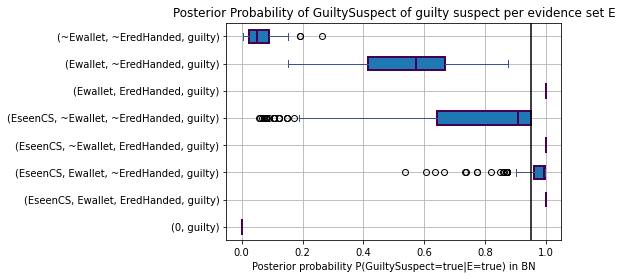

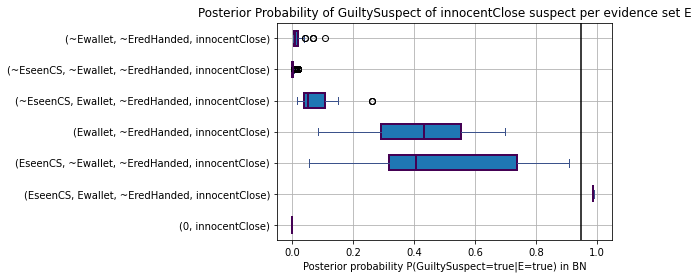

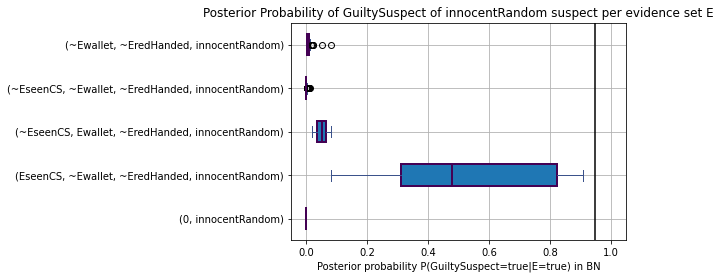

OPPORTUNITY


<ipython-input-106-daa2034a5031>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-106-daa2034a5031>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
295 innocentClose 1 5
0.989748973671701
		 295 1 5
{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
424 innocentClose 1 6
0.9872189717841721
		 424 1 6
1000 guilty 990
1000
1000 innocentClose 993
1000
1000 innocentRandom 993
1000
correctly classified as guilty (tp):  489
incorrectly classified as innocent (fn):  511
incorrectly classified as guilty (fp):  2
correctly classfied as innocent (tn):  998
mcc with threshold as 0.95 for innocentClose is 0.5657747941239816
correctly classified as guilty (tp):  489
incorrectly classified as innocent (fn):  511
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  1000
mcc with threshold as 0.95 for innocentRandom is 0.5688820064478157


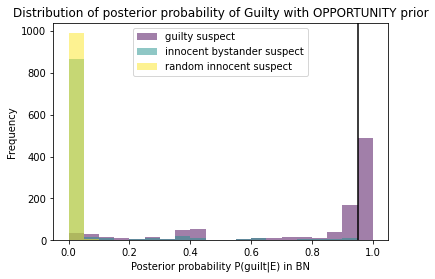

guilty vs innocentClose
0.0 & 1.0 & 1.0 & 0.999999999\\
0.01 & 0.987 & 0.207 & 4.768115918994609\\
0.02 & 0.982 & 0.161 & 6.099378844103237\\
0.03 & 0.97 & 0.152 & 6.381578905384349\\
0.04 & 0.968 & 0.141 & 6.865248178260651\\
0.05 & 0.963 & 0.133 & 7.2406014493187865\\
0.06 & 0.958 & 0.13 & 7.369230712544379\\
0.07 & 0.952 & 0.123 & 7.7398373354484775\\
0.08 & 0.946 & 0.121 & 7.818181753568746\\
0.09 & 0.938 & 0.116 & 8.086206826843044\\
0.1 & 0.935 & 0.116 & 8.060344758100477\\
0.11 & 0.927 & 0.109 & 8.504587077939568\\
0.12 & 0.927 & 0.109 & 8.504587077939568\\
0.13 & 0.92 & 0.105 & 8.76190467845805\\
0.14 & 0.92 & 0.105 & 8.76190467845805\\
0.15 & 0.918 & 0.104 & 8.826922992048818\\
0.16 & 0.913 & 0.103 & 8.864077583843907\\
0.17 & 0.912 & 0.103 & 8.85436884607409\\
0.18 & 0.911 & 0.103 & 8.844660108304272\\
0.19 & 0.91 & 0.102 & 8.921568539984623\\
0.2 & 0.907 & 0.102 & 8.892156775567091\\
0.21 & 0.907 & 0.102 & 8.892156775567091\\
0.22 & 0.907 & 0.102 & 8.892156775567091\\
0.23 &

0.76 & 0.723 & 0.003 & 240.99991966669344\\
0.77 & 0.718 & 0.003 & 239.33325355558213\\
0.78 & 0.713 & 0.003 & 237.66658744447085\\
0.79 & 0.713 & 0.003 & 237.66658744447085\\
0.8 & 0.709 & 0.002 & 354.4998227500886\\
0.81 & 0.709 & 0.002 & 354.4998227500886\\
0.82 & 0.708 & 0.002 & 353.9998230000885\\
0.83 & 0.708 & 0.002 & 353.9998230000885\\
0.84 & 0.698 & 0.002 & 348.99982550008724\\
0.85 & 0.698 & 0.002 & 348.99982550008724\\
0.86 & 0.696 & 0.002 & 347.99982600008695\\
0.87 & 0.665 & 0.002 & 332.4998337500831\\
0.88 & 0.657 & 0.002 & 328.4998357500821\\
0.89 & 0.657 & 0.002 & 328.4998357500821\\
0.9 & 0.657 & 0.002 & 328.4998357500821\\
0.91 & 0.529 & 0.0 & 529000000.0\\
0.92 & 0.521 & 0.0 & 521000000.0\\
0.93 & 0.506 & 0.0 & 506000000.0\\
0.94 & 0.489 & 0.0 & 489000000.0\\
0.95 & 0.489 & 0.0 & 489000000.0\\
0.96 & 0.199 & 0.0 & 199000000.0\\
0.97 & 0.198 & 0.0 & 198000000.0\\
0.98 & 0.192 & 0.0 & 192000000.0\\
0.99 & 0.184 & 0.0 & 184000000.0\\
guilty vs innocentRandom
0.85 & 0.6

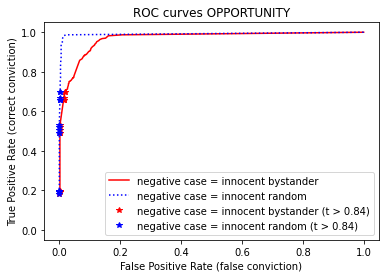

 guilty and at CS
0    709
1    291
Name: E, dtype: int64
 guilty and not at CS
Series([], Name: E, dtype: int64)
 not guilty and at CS
0    49
Name: E, dtype: int64
 not guilty and not at CS
0    1910
1      41
Name: E, dtype: int64
{'p_redhanded_given_guilty': 0.013000000000000012, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.29100000000000004, 'p_Ewallet_given_notguilty': 0.020499999999999963, 'p_Eseen_given_guilty': 0.905, 'p_Eseen_given_notguilty': 0.0575, 'p_Eseen_given_atCS': 0.951, 'p_Eseen_given_notatCS': 0.0345, 'p_Ewallet_given_guilty_CS': 0.29100000000000004, 'p_Ewallet_given_guilty_notCS': 0, 'p_Ewallet_given_notguilty_CS': 0.9755, 'p_Ewallet_given_notguilty_notCS': 0.04500000000000004}
LEGAL


<ipython-input-92-e021a4b3ca8d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-92-e021a4b3ca8d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


1000 guilty 990
1000
1000
1000 innocentClose 993
1000
1000
1000 innocentRandom 993
1000
1000


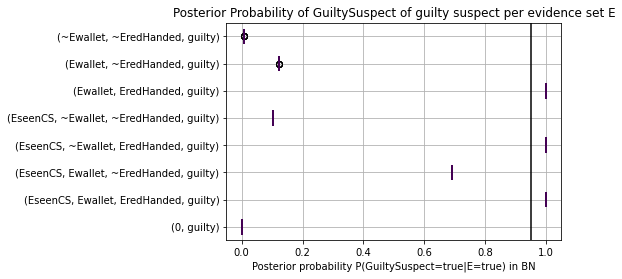

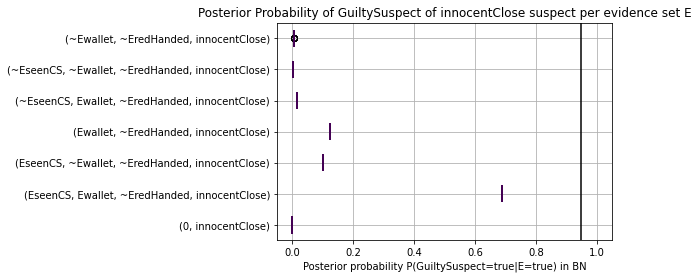

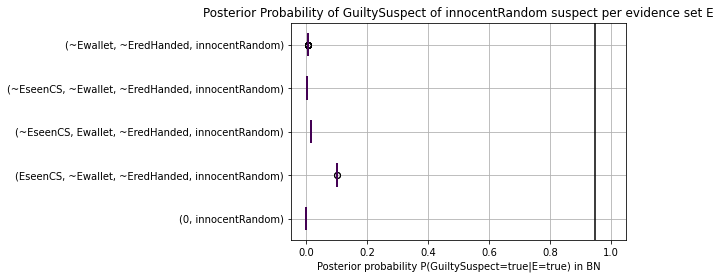

LEGAL


<ipython-input-106-daa2034a5031>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-106-daa2034a5031>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
295 innocentClose 1 5
0.6901548395406518
{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
424 innocentClose 1 6
0.6901548395406517
1000 guilty 990
1000
1000 innocentClose 993
1000
1000 innocentRandom 993
1000
correctly classified as guilty (tp):  13
incorrectly classified as innocent (fn):  987
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  1000
mcc with threshold as 0.95 for innocentClose is 0.0808858851824057
correctly classified as guilty (tp):  13
incorrectly classified as innocent (fn):  987
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  1000
mcc with threshold as 0.95 for innocentRandom is 0.0808858851824057


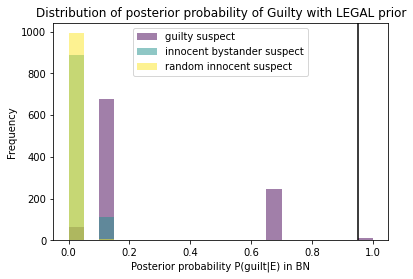

guilty vs innocentClose
0.0 & 1.0 & 1.0 & 0.999999999\\
0.01 & 0.936 & 0.144 & 6.499999954861112\\
0.02 & 0.936 & 0.113 & 8.283185767405437\\
0.03 & 0.936 & 0.113 & 8.283185767405437\\
0.04 & 0.936 & 0.113 & 8.283185767405437\\
0.05 & 0.936 & 0.113 & 8.283185767405437\\
0.06 & 0.936 & 0.113 & 8.283185767405437\\
0.07 & 0.936 & 0.113 & 8.283185767405437\\
0.08 & 0.936 & 0.113 & 8.283185767405437\\
0.09 & 0.936 & 0.113 & 8.283185767405437\\
0.1 & 0.936 & 0.113 & 8.283185767405437\\
0.11 & 0.291 & 0.008 & 36.37499545312557\\
0.12 & 0.291 & 0.008 & 36.37499545312557\\
0.13 & 0.261 & 0.002 & 130.49993475003262\\
0.14 & 0.261 & 0.002 & 130.49993475003262\\
0.15 & 0.261 & 0.002 & 130.49993475003262\\
0.16 & 0.261 & 0.002 & 130.49993475003262\\
0.17 & 0.261 & 0.002 & 130.49993475003262\\
0.18 & 0.261 & 0.002 & 130.49993475003262\\
0.19 & 0.261 & 0.002 & 130.49993475003262\\
0.2 & 0.261 & 0.002 & 130.49993475003262\\
0.21 & 0.261 & 0.002 & 130.49993475003262\\
0.22 & 0.261 & 0.002 & 130.4999347

0.91 & 0.013 & 0.0 & 13000000.0\\
0.92 & 0.013 & 0.0 & 13000000.0\\
0.93 & 0.013 & 0.0 & 13000000.0\\
0.94 & 0.013 & 0.0 & 13000000.0\\
0.95 & 0.013 & 0.0 & 13000000.0\\
0.96 & 0.013 & 0.0 & 13000000.0\\
0.97 & 0.013 & 0.0 & 13000000.0\\
0.98 & 0.013 & 0.0 & 13000000.0\\
0.99 & 0.013 & 0.0 & 13000000.0\\


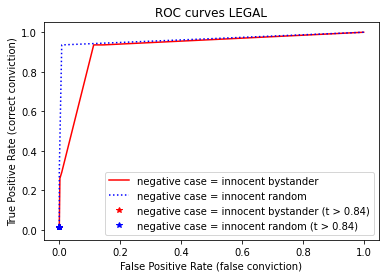

In [108]:
run_analysis("OPPORTUNITY", 3) # true prior with small n
run_analysis("LEGAL", 3) # true prior with small n

#run_analysis("EXTRAARC", 3) # true prior with small n


In [92]:
#def alt_results(n):
def calculate_posteriors_alt(params, prior_method, evidence_d, true_prior):
    print(prior_method)
    

    # load in dataset
    #params= pd.read_csv("paramsNew.csv")
    params = params.loc[params["seen"] != 200] # only get with IDs
    RUN_NUM = 1000 #(len(params)/3) 

    params['Eseen'] = params['Eseen.Eseen']
    params["Eseen"] = params["Eseen"].astype('Int64')
    
    params = params.reset_index()
    dict_outcomes = {"guiltyEV":[], "guilty":[],
                     "innocentCloseEV":[], "innocentClose": [],
                     "innocentRandomEV":[], "innocentRandom": []}
    
    
    # load in bayesian network
    

    if prior_method == "OPPORTUNITY":
        bn=gum.loadBN('finalOpportunity.net')
        
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
    
    elif prior_method == "REASON":
        bn=gum.loadBN('reasonBN.net')
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
    
    elif prior_method == "EXTRAARC":
        bn=gum.loadBN('finalOpportunityExtraArc.net')
        
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
        
        g1 = evidence_d["p_Ewallet_given_guilty_CS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1, "guiltySuspect":1}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_notguilty_CS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1, "guiltySuspect":0}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_guilty_notCS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0, "guiltySuspect":1}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_notguilty_notCS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0, "guiltySuspect":0}] = [1 - g1, g1]
    

    else:
        bn=gum.loadBN('finalBNevIdiom.net')
        
        g1 = evidence_d["p_Eseen_given_guilty"]
        g0 = evidence_d['p_Eseen_given_notguilty']
        
        bn.cpt("EcameraSeenAtCS")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
        bn.cpt("EcameraSeenAtCS")[{"guiltySuspect":0}] = [1-g0, g0]
    
    
    

    if prior_method != "EXTRAARC":
        g1 = evidence_d["p_Ewallet_given_guilty"]
        g0 = evidence_d['p_Ewallet_given_notguilty']
    
        bn.cpt("Ewallet")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
        bn.cpt("Ewallet")[{"guiltySuspect":0}] = [1-g0, g0]
 
 
    g1 = evidence_d["p_redhanded_given_guilty"]
    g0 = evidence_d['p_redhanded_given_notguilty']
 
    bn.cpt("EredHanded")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
    bn.cpt("EredHanded")[{"guiltySuspect":0}] = [1-g0, g0]
    
    
    
    if true_prior == 1:
        opp_column = "opp"
        guilt_column = "guilty"
    elif true_prior == 2:
        opp_column = "oppSeen"
        guilt_column = "guiltySeen"
    elif true_prior == 3:
        opp_column = "oppSmalln"
        guilt_column = "guiltySmalln"
    elif true_prior == 4:
        opp_column = "oppSeenSmalln"
        guilt_column = "guiltySeenSmalln"
        
    
    for index, row in params.iterrows():
        #print(str(row["type"]))
        if str(row["type"]) == "nan":
            print("this row is full of nans")
            continue
        
        if prior_method == "OPPORTUNITY" or prior_method == "EXTRAARC":
            P_oppPrior = row[opp_column]
            P_guilty = row[guilt_column]
            bn.cpt("suspectAtCrimeScene")[{}] = [1-P_oppPrior, P_oppPrior]
            bn.cpt("guiltySuspect")[{"suspectAtCrimeScene":1}] = [1-P_guilty, P_guilty]
            bn.cpt("guiltySuspect")[{"suspectAtCrimeScene":0}] = [1, 0]
            
            #print(f"n = {row['getsmalln']}")
            #print(f"N = {row['n']}")
        elif prior_method == "REASON":
            P_guilty = (row['getsmalln']-1)/200 # there are x out of 200 people at CS

            bn.cpt("guiltySuspect")[{}] = [1-0.01, 0.01]
            
            bn.cpt("suspectAtCrimeScene")[{"guiltySuspect":1}] = [0, 1]
            bn.cpt("suspectAtCrimeScene")[{"guiltySuspect":0}] = [1-P_guilty,P_guilty]
            

        elif prior_method == "WORLD":
            bn.cpt("guiltySuspect")[{}]= [1-0.005, 0.005]
        elif prior_method == "LEGAL":
            bn.cpt("guiltySuspect")[{}] = [1-0.01, 0.01]
        else:
            print("prior method not implemented")
            exit()
            
       
        #print(row['E'], row['heterdaad'])
        
        ev_dict = {"Ewallet":int(row['E']), "EredHanded":int(row['heterdaad'])}


        if row['Eseen'] == 1 or row['Eseen'] == 0:
            ev_dict["EcameraSeenAtCS"]=row['Eseen']
            
        #print(row["type"])
        
                   
        try:
            s = gum.getPosterior(bn, evs=ev_dict, target="guiltySuspect")
        except Exception:
            print("exeption")
            s = [1, 0]
        
            
        
        
        #print(bn.cpt("suspectAtCrimeScene"))
        #print(bn.cpt("guiltySuspect"))
        
        #gnb.showInference(bn, evs=ev_dict)
        
        #Ewallet': 0, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
        ev_string = f""
        
        if 'EcameraSeenAtCS' in ev_dict.keys():
            if ev_dict["EcameraSeenAtCS"] == 1:
                ev_string = f"EseenCS, "
            elif ev_dict["EcameraSeenAtCS"] == 0:
                ev_string = f"~EseenCS, "
        
        if ev_dict["Ewallet"] == 1:
            ev_string += "Ewallet, "
        elif ev_dict["Ewallet"] == 0:
            ev_string += "~Ewallet, "
        
        if ev_dict["EredHanded"] == 1:
            ev_string += "EredHanded"
        elif ev_dict["EredHanded"] == 0:
            ev_string += "~EredHanded"
        
        
        
        key = row['type']
        x = dict_outcomes[key]
        x.append(s[1])
        dict_outcomes[key] = x
        
        #print(ev_dict)

        k_ev = f"{key}EV"
        x = dict_outcomes[k_ev]
        x.append(ev_string)
        dict_outcomes[k_ev] = x

        #print(dict_outcomes[k_ev], dict_outcomes[key])

    for type_suspect in ["guilty", "innocentClose", "innocentRandom"]:
        print(RUN_NUM, type_suspect, len(dict_outcomes[type_suspect]))
        while len(dict_outcomes[type_suspect]) < RUN_NUM:
            dict_outcomes[type_suspect].append(0)
            dict_outcomes[f"{type_suspect}EV"].append(0)

        print(len(dict_outcomes[type_suspect]))
        print(len(dict_outcomes[f"{type_suspect}EV"]))

    
    n = pd.DataFrame.from_dict(dict_outcomes)
    return n   


def plot_m(m, prior_method):
    for sus in ["guilty", "innocentClose", "innocentRandom"]:
        #print(m)
        #print(m.columns)
        ev = f"{sus}EV"
        d = m[[ev, sus]]
        
        t = f"Posterior Probability of GuiltySuspect of {sus} suspect per evidence set E"
    
        
        props = dict(boxes="#21918c", whiskers="#3b528b", medians="#440154", caps="#3b528b")
        boxprops = dict(linestyle='-', linewidth=2, color="#440154") #   # yellow = #fde725, green= "#5ec962"
        medianprops = dict(linestyle='-', linewidth=2, color="#440154")
        ax = d.groupby(ev).boxplot(sus, vert=False,
                  color=props, boxprops=boxprops,medianprops=medianprops, patch_artist=True)
        ax.set_xlim(-0.05, 1.05)
        ax.set_xlabel("Posterior probability P(GuiltySuspect=true|E=true) in BN")
        ax.set_title(t)
        ax.axvline(0.95, color = "black")
        #plt.figure(figsize=(8.0, 5.0))
        plt.savefig(f"jurixdraft/figures/bp{prior_method}{sus}.png", dpi=600, bbox_inches='tight')
        plt.show()
        
        #d_2 = d.groupby([f"{sus}EV"]).count()
        #print(d_2)
        #print(d_1)
        #print(d_1.columns)
        
        #ax = d_1.boxplot(sus)
        #ax.set_xlim(-0.05, 1.05)
        #ax.set_xlabel("Posterior probability P(GuiltySuspect=true|E) in BN")
        #ax.axvline(0.95, color = "black")
        #plt.show()
        

    

 guilty and at CS
0    709
1    291
Name: E, dtype: int64
 guilty and not at CS
Series([], Name: E, dtype: int64)
 not guilty and at CS
0    49
Name: E, dtype: int64
 not guilty and not at CS
0    1910
1      41
Name: E, dtype: int64
OPPORTUNITY


<ipython-input-92-e021a4b3ca8d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-92-e021a4b3ca8d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


1000 guilty 990
1000
1000
1000 innocentClose 993
1000
1000
1000 innocentRandom 993
1000
1000
LEGAL


<ipython-input-92-e021a4b3ca8d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-92-e021a4b3ca8d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


1000 guilty 990
1000
1000
1000 innocentClose 993
1000
1000
1000 innocentRandom 993
1000
1000
Index(['guiltyEV', 'guilty', 'innocentCloseEV', 'innocentClose',
       'innocentRandomEV', 'innocentRandom', 'prior'],
      dtype='object')
                           guiltyEV    guilty        prior
0    EseenCS, ~Ewallet, ~EredHanded  0.907806  Opportunity
1             ~Ewallet, ~EredHanded  0.024880  Opportunity
2    EseenCS, ~Ewallet, ~EredHanded  0.408080  Opportunity
3    EseenCS, ~Ewallet, ~EredHanded  0.907806  Opportunity
4     EseenCS, Ewallet, ~EredHanded  0.997417  Opportunity
..                              ...       ...          ...
985           ~Ewallet, ~EredHanded  0.007165        Legal
986  EseenCS, ~Ewallet, ~EredHanded  0.101996        Legal
987   EseenCS, Ewallet, ~EredHanded  0.690155        Legal
988  EseenCS, ~Ewallet, ~EredHanded  0.101996        Legal
989  EseenCS, ~Ewallet, ~EredHanded  0.101996        Legal

[1980 rows x 3 columns]
guiltyEV
[Text(0, 1, '(EseenCS, 

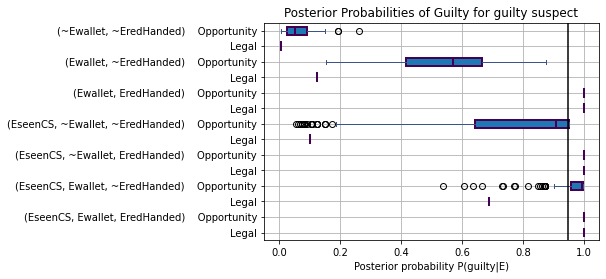

Index(['guiltyEV', 'guilty', 'innocentCloseEV', 'innocentClose',
       'innocentRandomEV', 'innocentRandom', 'prior'],
      dtype='object')
                     innocentCloseEV  innocentClose        prior
0    ~EseenCS, ~Ewallet, ~EredHanded       0.000200  Opportunity
1               Ewallet, ~EredHanded       0.400181  Opportunity
2    ~EseenCS, ~Ewallet, ~EredHanded       0.000754  Opportunity
3    ~EseenCS, ~Ewallet, ~EredHanded       0.000558  Opportunity
4    ~EseenCS, ~Ewallet, ~EredHanded       0.017806  Opportunity
..                               ...            ...          ...
988   EseenCS, ~Ewallet, ~EredHanded       0.101996        Legal
989  ~EseenCS, ~Ewallet, ~EredHanded       0.000727        Legal
990  ~EseenCS, ~Ewallet, ~EredHanded       0.000727        Legal
991  ~EseenCS, ~Ewallet, ~EredHanded       0.000727        Legal
992  ~EseenCS, ~Ewallet, ~EredHanded       0.000727        Legal

[1986 rows x 3 columns]
innocentCloseEV
[Text(0, 1, '(EseenCS, Ewallet, ~Ered

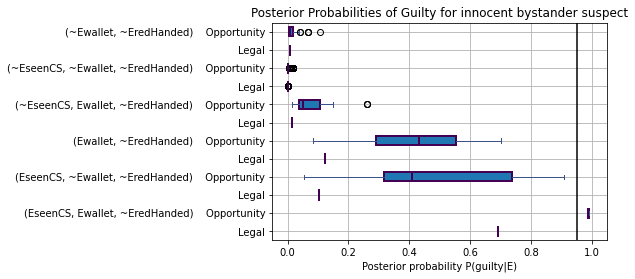

Index(['guiltyEV', 'guilty', 'innocentCloseEV', 'innocentClose',
       'innocentRandomEV', 'innocentRandom', 'prior'],
      dtype='object')
                    innocentRandomEV  innocentRandom        prior
0    ~EseenCS, ~Ewallet, ~EredHanded        0.000771  Opportunity
1    ~EseenCS, ~Ewallet, ~EredHanded        0.000198  Opportunity
2    ~EseenCS, ~Ewallet, ~EredHanded        0.000489  Opportunity
3    ~EseenCS, ~Ewallet, ~EredHanded        0.000200  Opportunity
4    ~EseenCS, ~Ewallet, ~EredHanded        0.000213  Opportunity
..                               ...             ...          ...
988  ~EseenCS, ~Ewallet, ~EredHanded        0.000727        Legal
989  ~EseenCS, ~Ewallet, ~EredHanded        0.000727        Legal
990  ~EseenCS, ~Ewallet, ~EredHanded        0.000727        Legal
991  ~EseenCS, ~Ewallet, ~EredHanded        0.000727        Legal
992  ~EseenCS, ~Ewallet, ~EredHanded        0.000727        Legal

[1986 rows x 3 columns]
innocentRandomEV
[Text(0, 1, '(EseenCS, ~

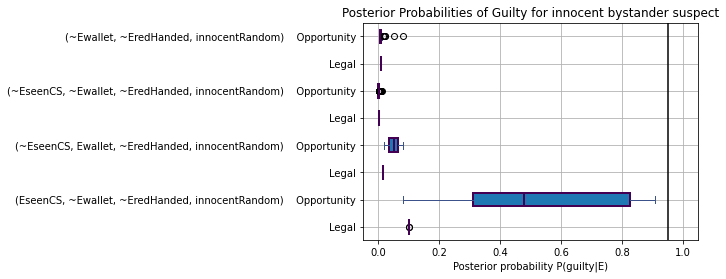

In [93]:
def effect_nN(params, prior_method, sus, evidence_d, true_prior):
    # load in dataset
    #params= pd.read_csv("paramsNew.csv")
    params = params.loc[params["seen"] != 200] # only get with IDs

    RUN_NUM = 1000 #(len(params)/3) 

    params['Eseen'] = params['Eseen.Eseen']
    params["Eseen"] = params["Eseen"].astype('Int64')
    
    params = params.reset_index()
    dict_outcomes = {"EV":[], "convicted_n":[], "acquitted_n":[], 
                     "convicted_N":[], "acquitted_N":[]}
    
    
    # load in bayesian network
    

    if prior_method == "OPPORTUNITY":
        bn=gum.loadBN('finalOpportunity.net')
        
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
    
    elif prior_method == "REASON":
        bn=gum.loadBN('reasonBN.net')
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
        
    elif prior_method == "EXTRAARC":
        bn=gum.loadBN('finalOpportunityExtraArc.net')
        
        g1 = evidence_d["p_Eseen_given_atCS"]
        g0 = evidence_d["p_Eseen_given_notatCS"]
        
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1}] = [1 - g1, g1]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0}] = [1 - g0, g0]
        
        g1 = evidence_d["p_Ewallet_given_guilty_CS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1, "guiltySuspect":1}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_notguilty_CS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":1, "guiltySuspect":0}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_guilty_notCS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0, "guiltySuspect":1}] = [1 - g1, g1]
        g1 = evidence_d["p_Ewallet_given_notguilty_notCS"]
        bn.cpt("EcameraSeenAtCS")[{"suspectAtCrimeScene":0, "guiltySuspect":0}] = [1 - g1, g1]
    

    else:
        bn=gum.loadBN('finalBNevIdiom.net')
        
        g1 = evidence_d["p_Eseen_given_guilty"]
        g0 = evidence_d['p_Eseen_given_notguilty']
        
        bn.cpt("EcameraSeenAtCS")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
        bn.cpt("EcameraSeenAtCS")[{"guiltySuspect":0}] = [1-g0, g0]
    
    
    

    
    if prior_method != "EXTRAARC":
        g1 = evidence_d["p_Ewallet_given_guilty"]
        g0 = evidence_d['p_Ewallet_given_notguilty']
    
        bn.cpt("Ewallet")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
        bn.cpt("Ewallet")[{"guiltySuspect":0}] = [1-g0, g0]
 
  
 
    g1 = evidence_d["p_redhanded_given_guilty"]
    g0 = evidence_d['p_redhanded_given_notguilty']
 
    bn.cpt("EredHanded")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
    bn.cpt("EredHanded")[{"guiltySuspect":0}] = [1-g0, g0]
    
    
    
    if true_prior == 1:
        opp_column = "opp"
        guilt_column = "guilty"
    elif true_prior == 2:
        opp_column = "oppSeen"
        guilt_column = "guiltySeen"
    elif true_prior == 3:
        opp_column = "oppSmalln"
        guilt_column = "guiltySmalln"
    elif true_prior == 4:
        opp_column = "oppSeenSmalln"
        guilt_column = "guiltySeenSmalln"
        
        
    
    for index, row in params.iterrows():
        #print(str(row["type"]))
        if str(row["type"]) == "nan":
            print("this row is full of nans")
            continue
        
        if prior_method == "OPPORTUNITY" or prior_method == "EXTRAARC":
            P_oppPrior = row[opp_column]
            P_guilty = row[guilt_column]
            bn.cpt("suspectAtCrimeScene")[{}] = [1-P_oppPrior, P_oppPrior]
            bn.cpt("guiltySuspect")[{"suspectAtCrimeScene":1}] = [1-P_guilty, P_guilty]
            bn.cpt("guiltySuspect")[{"suspectAtCrimeScene":0}] = [1, 0]
            
            #print(f"n = {row['getsmalln']}")
            #print(f"N = {row['n']}")
        elif prior_method == "REASON":
            P_guilty = (row['getsmalln']-1)/200 # there are x out of 200 people at CS

            bn.cpt("guiltySuspect")[{}] = [1-0.01, 0.01]
            
            bn.cpt("suspectAtCrimeScene")[{"guiltySuspect":1}] = [0, 1]
            bn.cpt("suspectAtCrimeScene")[{"guiltySuspect":0}] = [1-P_guilty,P_guilty]
            

        elif prior_method == "WORLD":
            bn.cpt("guiltySuspect")[{}]= [1-0.005, 0.005]
        elif prior_method == "LEGAL":
            bn.cpt("guiltySuspect")[{}] = [1-0.01, 0.01]
        else:
            print("prior method not implemented")
            exit()
            
       
        #print(row['E'], row['heterdaad'])
        
        ev_dict = {"Ewallet":int(row['E']), "EredHanded":int(row['heterdaad'])}


        if row['Eseen'] == 1 or row['Eseen'] == 0:
            ev_dict["EcameraSeenAtCS"]=row['Eseen']
            
        #print(row["type"])
        
                   
        try:
            s = gum.getPosterior(bn, evs=ev_dict, target="guiltySuspect")
        except Exception:
            print("exeption")
            s = [1, 0]
            
        if row["type"] == sus:
            
            if s[1] >= 0.95:
                key_n = "convicted_n"
                key_N = "convicted_N"
            else:
                key_n = "acquitted_n"
                key_N = "acquitted_N"



            x = dict_outcomes["EV"]
            x.append(str(ev_dict))
            dict_outcomes["EV"] = x

            x = dict_outcomes[key_n]
            x.append(row["getsmalln"])
            dict_outcomes[key_n] = x

            x = dict_outcomes[key_N]
            x.append(row["n"])
            dict_outcomes[key_N] = x

        
    print(len(dict_outcomes["convicted_n"]))
    print(len(dict_outcomes["convicted_N"]))
    print(len(dict_outcomes["acquitted_n"]))
    print(len(dict_outcomes["acquitted_N"]))

    
    #print(dict_outcomes)
    
    #pd.DataFrame.from_dict(dict_outcomes)
    
    #d = m[[ev, sus, "prior"]]
    
    n = [pd.Series(dict_outcomes["convicted_n"]), 
         pd.Series(dict_outcomes["convicted_N"]),
        pd.Series(dict_outcomes["acquitted_n"]),
        pd.Series(dict_outcomes["acquitted_N"])]
    return n  


def plot_m_both(m1, m2):
    #print(m1)
    #print(m2)
    m = pd.concat([m1, m2])
    for sus in ["guilty", "innocentClose", "innocentRandom"]:
        #print(m)
        print(m.columns)
        ev = f"{sus}EV"
        d = m[[ev, sus, "prior"]]
        d = d.loc[d[ev] != 0]
        print(d)
        print(ev)
        
        if sus == "guilty":
            sus_name = "guilty"
            
        if sus == "innocentClose":
            sus_name = "innocent bystander"
        tit = f"Posterior Probabilities of Guilty for {sus_name} suspect"
    
        
        props = dict(boxes="#21918c", whiskers="#3b528b", medians="#440154", caps="#3b528b")
        boxprops = dict(linestyle='-', linewidth=2, color="#440154") #   # yellow = #fde725, green= "#5ec962"
        medianprops = dict(linestyle='-', linewidth=2, color="#440154")
        ax = d.groupby([ev, "prior"]).boxplot(sus, vert=False,
                  color=props, boxprops=boxprops,medianprops=medianprops, patch_artist=True)
        ax.set_xlim(-0.05, 1.05)
        ax.set_xlabel("Posterior probability P(guilty|E)")
        #print(plt.yticks())
        locs, labels = plt.yticks()
        print(labels)
        labels_new = []
        for i in labels:
            print(i)
            t = i.get_text()
            t = re.sub(", guilty", '', t)
            t = re.sub(", innocentClose", '', t)
            #t = re.sub("(", '', t)
            #t = re.sub(")", '', t)
            if ", Legal" in t:
                t = re.sub(", Legal", '', t)
                t = "Legal"
            if ", Opportunity" in t:
                t = re.sub(", Opportunity", '', t)
                t = t + "    Opportunity"
            
            labels_new.append(t)
            #(EseenCS, ~Ewallet, ~EredHanded, Opportunity, guilty)
            #Text(0, 9, '(Ewallet, EredHanded, Legal, guilty)')
                    
        #locs = pd.array(range(1, 15))
        
        plt.yticks(locs, labels_new)
        ax.set_title(tit)
        ax.axvline(0.95, color = "black")
        #plt.figure(figsize=(8.0, 5.0))
        plt.savefig(f"jurixdraft/figures/bpTogether{sus}.png", dpi=600, bbox_inches='tight')
        plt.show()
    
params= pd.read_csv("paramsNew500.csv")
params = params.loc[params["vision-range"] == 25].copy()
RUN_NUM = len(params)/3

#print(RUN_NUM)

evidence = get_evidence(params, RUN_NUM)

# CALCULATE WITH EVIDENCE

m1 = calculate_posteriors_alt(params, "OPPORTUNITY", evidence, 3)
m1["prior"] = "Opportunity"
m2 = calculate_posteriors_alt(params, "LEGAL", evidence, 3) 
m2["prior"] = "Legal"
plot_m_both(m1, m2) 




In [94]:

'''
n_N_vals_opp  = effect_nN(params, "OPPORTUNITY", "guilty", evidence, 3)
t = f"Distribution of agents at crime scene (n)"
df = pd.DataFrame()

df = pd.DataFrame({"suspect convicted":n_N_vals_opp[0], "suspect acquitted":n_N_vals_opp[2]})

df.plot.hist(bins=20, alpha=0.5, 
                 title=t, cmap="winter")
ax.set_xlabel("Number of agents at crime scene (n)")
plt.savefig(f"jurixdraft/figures/nsmalldist.png", dpi=600)

plt.show()


t = f"Distribution of agents with the same opportunity as suspect(N)"

df = pd.DataFrame({"suspect convicted":n_N_vals_opp[1], "suspect acquitted":n_N_vals_opp[3]})

df.plot.hist(bins=100, alpha=0.5, 
                 title=t, cmap="winter")
ax.set_xlabel("Number of agents with same opportunity (N)")
plt.savefig(f"jurixdraft/figures/Ndist.png", dpi=600)

plt.show()

df = pd.DataFrame({"suspect convicted n":n_N_vals_opp[0],
                  "suspect convicted N":n_N_vals_opp[1],
                 "suspect acquitted n":n_N_vals_opp[2],
                 "suspect acquitted N":n_N_vals_opp[3]})

t = f"n and N guilty"

ax1 =  df.plot.scatter(x="suspect acquitted n", y="suspect acquitted N", 
                       color="#440154", label="acquitted cases", 
                       alpha=0.25)
df.plot.scatter(x="suspect convicted n", y="suspect convicted N", color='#5ec962',
                alpha=0.5, label="convicted cases",
                title=t, ax=ax1)

ax1.set_ylabel("Number of agents with same opportunity (N)")
ax1.set_xlabel("Number of agents at crime scene (n)")

plt.savefig(f"jurixdraft/figures/nNguilty.png", dpi=600)





n_N_vals_opp  = effect_nN(params, "OPPORTUNITY", "innocentClose", evidence, 3)
t = f"Distribution of agents at crime scene (n)"
df = pd.DataFrame()

df = pd.DataFrame({"suspect convicted":n_N_vals_opp[0], "suspect acquitted":n_N_vals_opp[2]})

df.plot.hist(bins=20, alpha=0.5, 
                 title=t, cmap="winter")
ax.set_xlabel("Number of agents at crime scene (n)")
plt.savefig(f"jurixdraft/figures/nsmalldist.png", dpi=600)

plt.show()


t = f"Distribution of agents with the same opportunity as suspect(N)"

df = pd.DataFrame({"suspect convicted":n_N_vals_opp[1], "suspect acquitted":n_N_vals_opp[3]})

df.plot.hist(bins=100, alpha=0.5, 
                 title=t, cmap="winter")
ax.set_xlabel("Number of agents with same opportunity (N)")
plt.savefig(f"jurixdraft/figures/Ndist.png", dpi=600)

plt.show()

df = pd.DataFrame({"suspect convicted n":n_N_vals_opp[0],
                  "suspect convicted N":n_N_vals_opp[1],
                 "suspect acquitted n":n_N_vals_opp[2],
                 "suspect acquitted N":n_N_vals_opp[3]})

t = f"n and N bystander"




ax1 =  df.plot.scatter(x="suspect acquitted n", y="suspect acquitted N", 
                       color="#440154", label="acquitted cases", 
                       alpha=0.25)
df.plot.scatter(x="suspect convicted n", y="suspect convicted N", color='#5ec962',
                alpha=0.5, label="convicted cases",
                title=t, ax=ax1)

ax1.set_ylabel("Number of agents with same opportunity (N)")
ax1.set_xlabel("Number of agents at crime scene (n)")

plt.savefig(f"jurixdraft/figures/nNbystander.png", dpi=600)




#sns.heatmap(df, annot=True)

plt.show()


#n_N_vals_legal = calculate_posteriors_alt(params, "LEGAL", evidence, 3) 
'''

'\nn_N_vals_opp  = effect_nN(params, "OPPORTUNITY", "guilty", evidence, 3)\nt = f"Distribution of agents at crime scene (n)"\ndf = pd.DataFrame()\n\ndf = pd.DataFrame({"suspect convicted":n_N_vals_opp[0], "suspect acquitted":n_N_vals_opp[2]})\n\ndf.plot.hist(bins=20, alpha=0.5, \n                 title=t, cmap="winter")\nax.set_xlabel("Number of agents at crime scene (n)")\nplt.savefig(f"jurixdraft/figures/nsmalldist.png", dpi=600)\n\nplt.show()\n\n\nt = f"Distribution of agents with the same opportunity as suspect(N)"\n\ndf = pd.DataFrame({"suspect convicted":n_N_vals_opp[1], "suspect acquitted":n_N_vals_opp[3]})\n\ndf.plot.hist(bins=100, alpha=0.5, \n                 title=t, cmap="winter")\nax.set_xlabel("Number of agents with same opportunity (N)")\nplt.savefig(f"jurixdraft/figures/Ndist.png", dpi=600)\n\nplt.show()\n\ndf = pd.DataFrame({"suspect convicted n":n_N_vals_opp[0],\n                  "suspect convicted N":n_N_vals_opp[1],\n                 "suspect acquitted n":n_N_vals_

In [95]:
#run_analysis("OPPORTUNITY", 3) # true prior with small n
#run_analysis("LEGAL", 3) # true prior with small n
#run_analysis("WORLD", 3) # true prior with small n

In [96]:
def run_analysis(prior_method, true_prior):
    
    params= pd.read_csv("paramsNew500.csv")
    #params= pd.read_csv("paramsNewp1515.csv")
    params = params.loc[params["vision-range"] == 25].copy()
    RUN_NUM = len(params)/3
    #print(RUN_NUM)

    evidence = get_evidence(params, RUN_NUM)
    print(evidence)
    
    # CALCULATE WITH EVIDENCE
    #n = calculate_posteriors(params, prior_method, evidence, true_prior)
    m = calculate_posteriors_alt(params, prior_method, evidence, true_prior) 
    #print(m)
    
    plot_m(m, prior_method)

    
    n = calculate_posteriors(params, prior_method, evidence, true_prior)

    # calculate mcc's for certain thresholds
    
    mcc_innocentClose = calculate_mcc("innocentClose", n)
    mcc_innocentRandom = calculate_mcc("innocentRandom", n)
    
    # create image of plot

    t = f"Distribution of posterior probability of Guilty with {prior_method} prior"
    ax = n.plot.hist( bins=20, alpha=0.5, 
                 title=t, cmap="viridis")
    ax.set_xlim(-0.05, 1.05)
    ax.set_xlabel("Posterior probability P(guilt|E) in BN")
    ax.axvline(0.95, color = "black")
    ax.legend(labels=["guilty suspect", "innocent bystander suspect", "random innocent suspect"])
    plt.viridis()
    plt.savefig(f"jurixdraft/figures/posterior{prior_method}.png", dpi=600)

    plt.show()

    
    plt.figure(1) 
    # create roc curve
    FPR_collected, TPR_collected = ROC_curve(n, "innocentClose", RUN_NUM,1)
    iCROC1 = ("innocentClose", FPR_collected, TPR_collected)
    
    FPR_collected, TPR_collected = ROC_curve(n, "innocentClose", RUN_NUM,2)
    iCROC2 = ("innocentClose", FPR_collected, TPR_collected)
    #plotROCS(FPR_collected, TPR_collected, "innocentClose", "blue", prior_method)

    
    FPR_collected, TPR_collected = ROC_curve(n, "innocentRandom", RUN_NUM, 1)
    iRROC1 = ("innocentRandom", FPR_collected, TPR_collected)
    
    FPR_collected, TPR_collected = ROC_curve(n, "innocentRandom", RUN_NUM, 2)
    iRROC2 = ("innocentRandom", FPR_collected, TPR_collected)
    
    plotROCStogether(prior_method, iCROC1, iCROC2, iRROC1, iRROC2)

    #plotROCS(FPR_collected, TPR_collected, "innocentRandom", "red", prior_method)


 guilty and at CS
0    709
1    291
Name: E, dtype: int64
 guilty and not at CS
Series([], Name: E, dtype: int64)
 not guilty and at CS
0    49
Name: E, dtype: int64
 not guilty and not at CS
0    1910
1      41
Name: E, dtype: int64
{'p_redhanded_given_guilty': 0.013000000000000012, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.29100000000000004, 'p_Ewallet_given_notguilty': 0.020499999999999963, 'p_Eseen_given_guilty': 0.905, 'p_Eseen_given_notguilty': 0.0575, 'p_Eseen_given_atCS': 0.951, 'p_Eseen_given_notatCS': 0.0345, 'p_Ewallet_given_guilty_CS': 0.29100000000000004, 'p_Ewallet_given_guilty_notCS': 0, 'p_Ewallet_given_notguilty_CS': 0.9755, 'p_Ewallet_given_notguilty_notCS': 0.04500000000000004}
OPPORTUNITY


<ipython-input-92-e021a4b3ca8d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-92-e021a4b3ca8d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


1000 guilty 990
1000
1000
1000 innocentClose 993
1000
1000
1000 innocentRandom 993
1000
1000


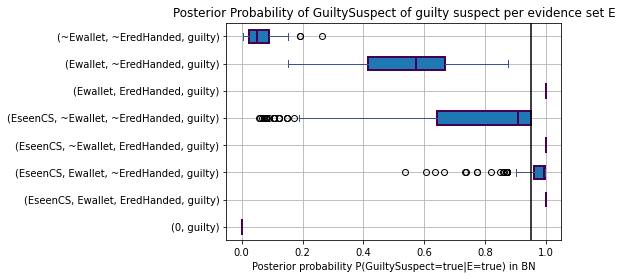

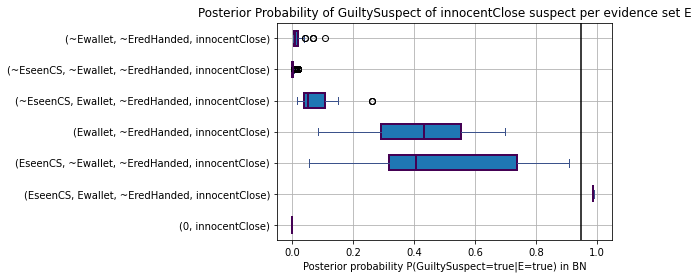

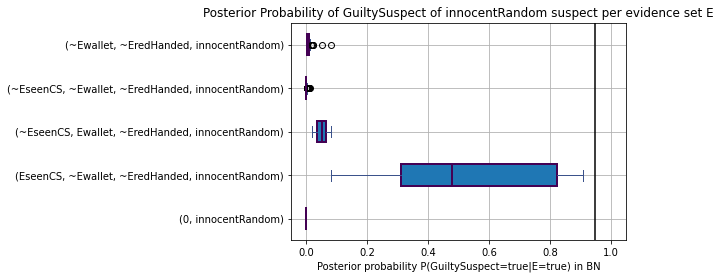

OPPORTUNITY


<ipython-input-89-0040d16e758b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-89-0040d16e758b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
295 innocentClose 1 5
0.989748973671701
		 295 1 5
{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
424 innocentClose 1 6
0.9872189717841721
		 424 1 6
1000 guilty 990
1000
1000 innocentClose 993
1000
1000 innocentRandom 993
1000
correctly classified as guilty (tp):  489
incorrectly classified as innocent (fn):  511
incorrectly classified as guilty (fp):  2
correctly classfied as innocent (tn):  998
mcc with threshold as 0.95 for innocentClose is 0.5657747941239816
correctly classified as guilty (tp):  489
incorrectly classified as innocent (fn):  511
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  1000
mcc with threshold as 0.95 for innocentRandom is 0.5688820064478157


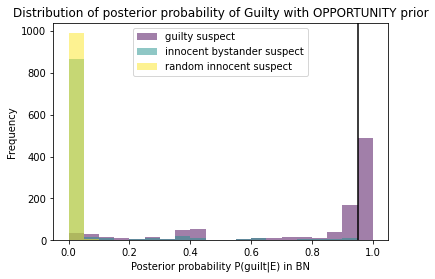

guilty vs innocentClose
0.0 & 1.0 & 1.0 \\
0.01 & 0.987 & 0.207 \\
0.02 & 0.982 & 0.161 \\
0.03 & 0.97 & 0.152 \\
0.04 & 0.968 & 0.141 \\
0.05 & 0.963 & 0.133 \\
0.06 & 0.958 & 0.13 \\
0.07 & 0.952 & 0.123 \\
0.08 & 0.946 & 0.121 \\
0.09 & 0.938 & 0.116 \\
0.1 & 0.935 & 0.116 \\
0.11 & 0.927 & 0.109 \\
0.12 & 0.927 & 0.109 \\
0.13 & 0.92 & 0.105 \\
0.14 & 0.92 & 0.105 \\
0.15 & 0.918 & 0.104 \\
0.16 & 0.913 & 0.103 \\
0.17 & 0.912 & 0.103 \\
0.18 & 0.911 & 0.103 \\
0.19 & 0.91 & 0.102 \\
0.2 & 0.907 & 0.102 \\
0.21 & 0.907 & 0.102 \\
0.22 & 0.907 & 0.102 \\
0.23 & 0.905 & 0.1 \\
0.24 & 0.904 & 0.099 \\
0.25 & 0.903 & 0.097 \\
0.26 & 0.888 & 0.089 \\
0.27 & 0.887 & 0.086 \\
0.28 & 0.887 & 0.086 \\
0.29 & 0.886 & 0.086 \\
0.3 & 0.885 & 0.086 \\
0.31 & 0.885 & 0.086 \\
0.32 & 0.885 & 0.084 \\
0.33 & 0.883 & 0.082 \\
0.34 & 0.88 & 0.082 \\
0.35 & 0.879 & 0.08 \\
0.36 & 0.872 & 0.077 \\
0.37 & 0.866 & 0.075 \\
0.38 & 0.863 & 0.072 \\
0.39 & 0.858 & 0.067 \\
0.4 & 0.829 & 0.06 \\
0.41 & 0.77

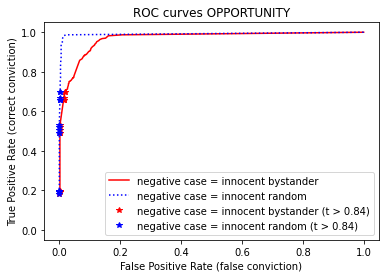

 guilty and at CS
0    709
1    291
Name: E, dtype: int64
 guilty and not at CS
Series([], Name: E, dtype: int64)
 not guilty and at CS
0    49
Name: E, dtype: int64
 not guilty and not at CS
0    1910
1      41
Name: E, dtype: int64
{'p_redhanded_given_guilty': 0.013000000000000012, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.29100000000000004, 'p_Ewallet_given_notguilty': 0.020499999999999963, 'p_Eseen_given_guilty': 0.905, 'p_Eseen_given_notguilty': 0.0575, 'p_Eseen_given_atCS': 0.951, 'p_Eseen_given_notatCS': 0.0345, 'p_Ewallet_given_guilty_CS': 0.29100000000000004, 'p_Ewallet_given_guilty_notCS': 0, 'p_Ewallet_given_notguilty_CS': 0.9755, 'p_Ewallet_given_notguilty_notCS': 0.04500000000000004}
LEGAL


<ipython-input-92-e021a4b3ca8d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-92-e021a4b3ca8d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


1000 guilty 990
1000
1000
1000 innocentClose 993
1000
1000
1000 innocentRandom 993
1000
1000


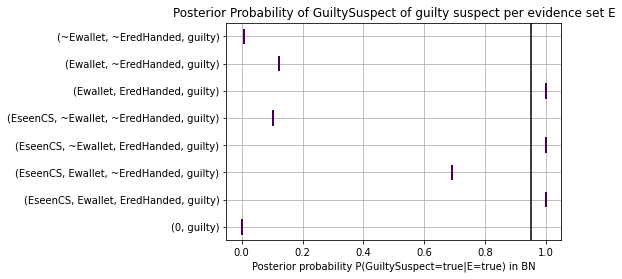

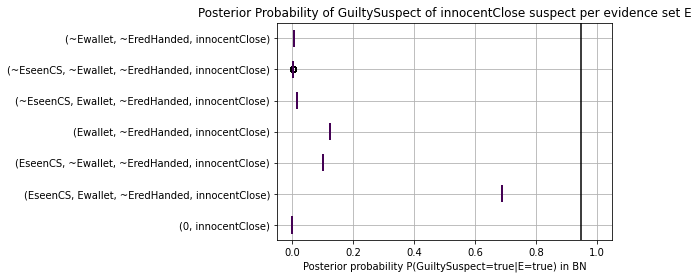

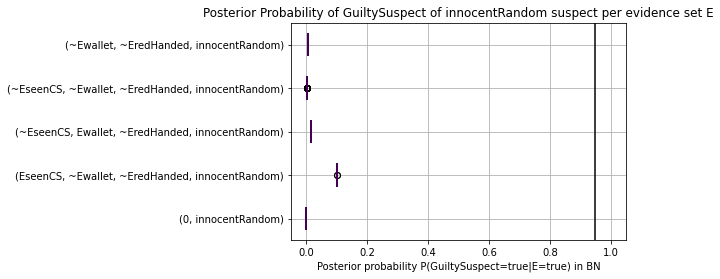

LEGAL


<ipython-input-89-0040d16e758b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-89-0040d16e758b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
295 innocentClose 1 5
0.6901548395406518
{'Ewallet': 1, 'EredHanded': 0, 'EcameraSeenAtCS': 1}
wal 1 cam 1
424 innocentClose 1 6
0.6901548395406518
1000 guilty 990
1000
1000 innocentClose 993
1000
1000 innocentRandom 993
1000
correctly classified as guilty (tp):  13
incorrectly classified as innocent (fn):  987
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  1000
mcc with threshold as 0.95 for innocentClose is 0.0808858851824057
correctly classified as guilty (tp):  13
incorrectly classified as innocent (fn):  987
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  1000
mcc with threshold as 0.95 for innocentRandom is 0.0808858851824057


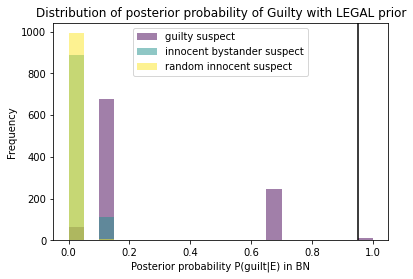

guilty vs innocentClose
0.0 & 1.0 & 1.0 \\
0.01 & 0.936 & 0.144 \\
0.02 & 0.936 & 0.113 \\
0.03 & 0.936 & 0.113 \\
0.04 & 0.936 & 0.113 \\
0.05 & 0.936 & 0.113 \\
0.06 & 0.936 & 0.113 \\
0.07 & 0.936 & 0.113 \\
0.08 & 0.936 & 0.113 \\
0.09 & 0.936 & 0.113 \\
0.1 & 0.936 & 0.113 \\
0.11 & 0.291 & 0.008 \\
0.12 & 0.291 & 0.008 \\
0.13 & 0.261 & 0.002 \\
0.14 & 0.261 & 0.002 \\
0.15 & 0.261 & 0.002 \\
0.16 & 0.261 & 0.002 \\
0.17 & 0.261 & 0.002 \\
0.18 & 0.261 & 0.002 \\
0.19 & 0.261 & 0.002 \\
0.2 & 0.261 & 0.002 \\
0.21 & 0.261 & 0.002 \\
0.22 & 0.261 & 0.002 \\
0.23 & 0.261 & 0.002 \\
0.24 & 0.261 & 0.002 \\
0.25 & 0.261 & 0.002 \\
0.26 & 0.261 & 0.002 \\
0.27 & 0.261 & 0.002 \\
0.28 & 0.261 & 0.002 \\
0.29 & 0.261 & 0.002 \\
0.3 & 0.261 & 0.002 \\
0.31 & 0.261 & 0.002 \\
0.32 & 0.261 & 0.002 \\
0.33 & 0.261 & 0.002 \\
0.34 & 0.261 & 0.002 \\
0.35 & 0.261 & 0.002 \\
0.36 & 0.261 & 0.002 \\
0.37 & 0.261 & 0.002 \\
0.38 & 0.261 & 0.002 \\
0.39 & 0.261 & 0.002 \\
0.4 & 0.261 & 0.002 \\
0

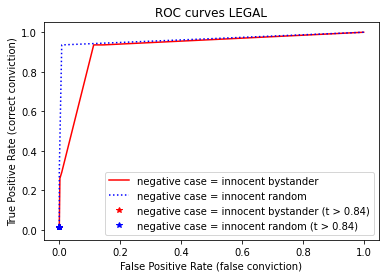

In [97]:

#run_analysis("EXTRAARC", 3) # true prior with small n

run_analysis("OPPORTUNITY", 3) # true prior with small n
run_analysis("LEGAL", 3) # true prior with small n
#run_analysis("WORLD", 3) # true prior with small n


In [319]:
params= pd.read_csv("paramsNew500.csv")
params

,Unnamed: 0,runNumber,vision-range,type,n,seen,agent,Eseen.runNumber,Eseen.Eseen,getsmalln,...,E,totalAgents,guilty,opp,guiltySeen,oppSeen,guiltySmalln,oppSmalln,guiltySeenSmalln,oppSeenSmalln
0,1,1,25,guilty,3,3,8,1.0,1.0,1,...,0,200,0.333333,0.015,0.333333,0.015,1.0,0.333333,1.0,0.333333
1,2,1,25,innocentClose,182,162,62,1.0,0.0,1,...,0,200,0.005495,0.910,0.006173,0.810,1.0,0.005495,1.0,0.006173
2,3,1,25,innocentRandom,48,48,9,1.0,0.0,1,...,0,200,0.020833,0.240,0.020833,0.240,1.0,0.020833,1.0,0.020833
3,4,2,25,guilty,29,16,8,2.0,-1.0,1,...,0,200,0.034483,0.145,0.062500,0.080,1.0,0.034483,1.0,0.062500
4,5,2,25,innocentClose,22,12,35,2.0,-1.0,1,...,1,200,0.045455,0.110,0.083333,0.060,1.0,0.045455,1.0,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,999,25,innocentClose,20,20,35,999.0,0.0,1,...,0,200,0.050000,0.100,0.050000,0.100,1.0,0.050000,1.0,0.050000
2996,2997,999,25,innocentRandom,19,19,9,999.0,0.0,1,...,0,200,0.052632,0.095,0.052632,0.095,1.0,0.052632,1.0,0.052632
2997,2998,1000,25,guilty,2,2,8,1000.0,1.0,1,...,0,200,0.500000,0.010,0.500000,0.010,1.0,0.500000,1.0,0.500000
2998,2999,1000,25,innocentClose,109,90,25,1000.0,0.0,1,...,0,200,0.009174,0.545,0.011111,0.450,1.0,0.009174,1.0,0.011111


In [214]:
f = []
for prior_method in ["OPPORTUNITY", "LEGAL", "WORLD"]:
    list_name = [prior_method]
    for val in [25]: #[1, 5, 10]:
        if prior_method != "OPPORTUNITY":
            mcc_innocentClose = run_mcc_analysis(prior_method, 1, val)
        else:
            mcc_innocentClose = run_mcc_analysis(prior_method, 3, val)
        list_name.append(mcc_innocentClose)
    f.append(list_name)
    
l = ["value", 25] #1, 5, 10] # 1, 5, 10, 15, 20, 25, 30
for i in range(0, len(l)):
    print(l[i], f[0][i], f[1][i])

        



{'p_redhanded_given_guilty': 0.010000000000000009, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.31000000000000005, 'p_Ewallet_given_notguilty': 0.02833333333333332, 'p_Eseen_given_guilty': 0.8666666666666667, 'p_Eseen_given_notguilty': 0.04666666666666667, 'p_Eseen_given_atCS': 0.9133333333333333, 'p_Eseen_given_notatCS': 0.023333333333333334}
OPPORTUNITY


<ipython-input-211-855b463bb8cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-211-855b463bb8cc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


297.3333333333333 guilty 296
298
297.3333333333333 innocentClose 298
298
297.3333333333333 innocentRandom 298
298
for prior OPPORTUNITY and value 25
correctly classified as guilty (tp):  162
incorrectly classified as innocent (fn):  136
incorrectly classified as guilty (fp):  1
correctly classfied as innocent (tn):  297
mcc with threshold as 0.95 for innocentClose is 0.606021630642586
correctly classified as guilty (tp):  162
incorrectly classified as innocent (fn):  136
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  298
mcc with threshold as 0.95 for innocentRandom is 0.6109598099719176
{'p_redhanded_given_guilty': 0.010000000000000009, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.31000000000000005, 'p_Ewallet_given_notguilty': 0.02833333333333332, 'p_Eseen_given_guilty': 0.8666666666666667, 'p_Eseen_given_notguilty': 0.04666666666666667, 'p_Eseen_given_atCS': 0.9133333333333333, 'p_Eseen_given_notatCS': 0.023333333333333334}
LEGAL


<ipython-input-211-855b463bb8cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-211-855b463bb8cc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


297.3333333333333 guilty 296
298
297.3333333333333 innocentClose 298
298
297.3333333333333 innocentRandom 298
298
for prior LEGAL and value 25
correctly classified as guilty (tp):  3
incorrectly classified as innocent (fn):  295
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  298
mcc with threshold as 0.95 for innocentClose is 0.07112680171657046
correctly classified as guilty (tp):  3
incorrectly classified as innocent (fn):  295
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  298
mcc with threshold as 0.95 for innocentRandom is 0.07112680171657046
{'p_redhanded_given_guilty': 0.010000000000000009, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.31000000000000005, 'p_Ewallet_given_notguilty': 0.02833333333333332, 'p_Eseen_given_guilty': 0.8666666666666667, 'p_Eseen_given_notguilty': 0.04666666666666667, 'p_Eseen_given_atCS': 0.9133333333333333, 'p_Eseen_given_notatCS': 0.023333333333333334}
WORLD


<ipython-input-211-855b463bb8cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-211-855b463bb8cc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


297.3333333333333 guilty 296
298
297.3333333333333 innocentClose 298
298
297.3333333333333 innocentRandom 298
298
for prior WORLD and value 25
correctly classified as guilty (tp):  3
incorrectly classified as innocent (fn):  295
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  298
mcc with threshold as 0.95 for innocentClose is 0.07112680171657046
correctly classified as guilty (tp):  3
incorrectly classified as innocent (fn):  295
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  298
mcc with threshold as 0.95 for innocentRandom is 0.07112680171657046
value OPPORTUNITY LEGAL
25 0.606021630642586 0.07112680171657046


{'p_redhanded_given_guilty': 0.010000000000000009, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.31000000000000005, 'p_Ewallet_given_notguilty': 0.02833333333333332, 'p_Eseen_given_guilty': 0.8666666666666667, 'p_Eseen_given_notguilty': 0.04666666666666667, 'p_Eseen_given_atCS': 0.9133333333333333, 'p_Eseen_given_notatCS': 0.023333333333333334}
OPPORTUNITY


<ipython-input-216-f8edfad0eb6f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-216-f8edfad0eb6f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


297.3333333333333 guilty 296
298
297.3333333333333 innocentClose 298
298
297.3333333333333 innocentRandom 298
298
correctly classified as guilty (tp):  162
incorrectly classified as innocent (fn):  136
incorrectly classified as guilty (fp):  1
correctly classfied as innocent (tn):  297
mcc with threshold as 0.95 for innocentClose is 0.606021630642586
correctly classified as guilty (tp):  162
incorrectly classified as innocent (fn):  136
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  298
mcc with threshold as 0.95 for innocentRandom is 0.6109598099719176


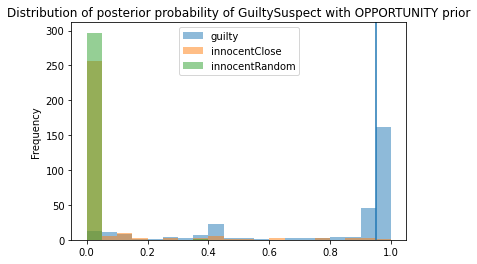

guilty vs innocentClose
0.95 & 0.54 & 0.0033333333333333335 \\
0.96 & 0.5366666666666666 & 0.0033333333333333335 \\
0.97 & 0.21333333333333335 & 0.0033333333333333335 \\
0.98 & 0.20333333333333334 & 0.0033333333333333335 \\
0.99 & 0.20333333333333334 & 0.0033333333333333335 \\


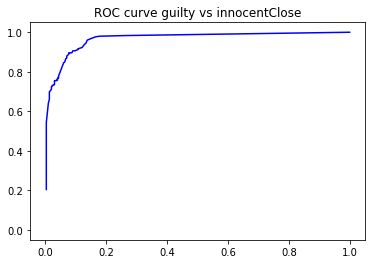

guilty vs innocentRandom
0.95 & 0.54 & 0.0 \\
0.96 & 0.5366666666666666 & 0.0 \\
0.97 & 0.21333333333333335 & 0.0 \\
0.98 & 0.20333333333333334 & 0.0 \\
0.99 & 0.20333333333333334 & 0.0 \\


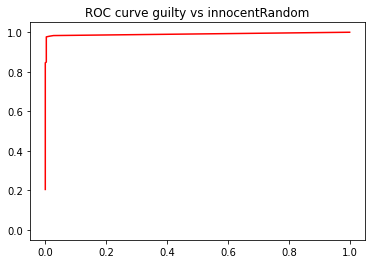

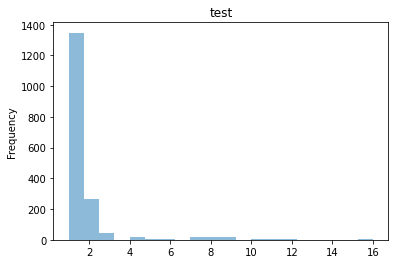

In [119]:
ax = params['getsmalln'].plot.hist(bins=20, alpha=0.5, 
                 title="test")


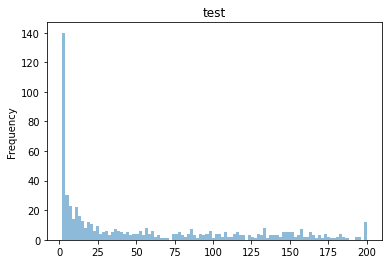

In [31]:
ax = params['n'].plot.hist(bins=100, alpha=0.5, 
                 title="test")

In [130]:
#params= pd.read_csv("paramsNew.csv")   

res = []
for index, row in params.iterrows():
    x = row["getidsA"][1:-1]
    x = x.split()
    if str(row["agent"]) in x:
        res.append(1)
    else:
        if row["Eseen.Eseen"] > 0:
            print(row["agent"], row["getidsA"], row["Eseen.Eseen"]) # am looking for: seen but not at CS
        res.append(0)
params["atCS"] = res




{'p_redhanded_given_guilty': 0.0, 'p_redhanded_given_notguilty': 0.0, 'p_Ewallet_given_guilty': 0.4, 'p_Ewallet_given_notguilty': 0.0, 'p_Eseen_given_guilty': 0, 'p_Eseen_given_notguilty': 0, 'p_Eseen_given_atCS': 0, 'p_Eseen_given_notatCS': 0}
REASON
1
5
9
correctly classified as guilty (tp):  1
incorrectly classified as innocent (fn):  9
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  10
mcc with threshold as 0.95 for innocentClose is 0.22941573387056174
correctly classified as guilty (tp):  1
incorrectly classified as innocent (fn):  9
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  10
mcc with threshold as 0.95 for innocentRandom is 0.22941573387056174


<ipython-input-128-180040244218>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-128-180040244218>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


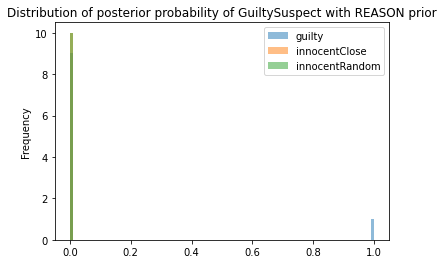

guilty vs innocentClose
0.95 & 0.1 & 0.0 \\
0.96 & 0.1 & 0.0 \\
0.97 & 0.1 & 0.0 \\
0.98 & 0.1 & 0.0 \\
0.99 & 0.1 & 0.0 \\


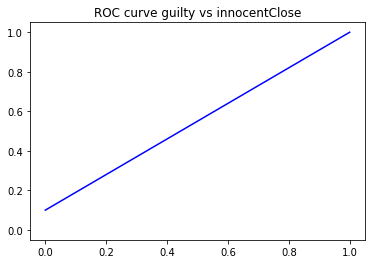

guilty vs innocentRandom
0.95 & 0.1 & 0.0 \\
0.96 & 0.1 & 0.0 \\
0.97 & 0.1 & 0.0 \\
0.98 & 0.1 & 0.0 \\
0.99 & 0.1 & 0.0 \\


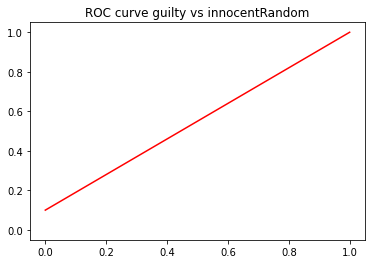

In [131]:
run_analysis("REASON", evidence, 3) # true prior with small n


NameError: name 'evidence' is not defined

LEGAL
1
5
9
correctly classified as guilty (tp):  1
incorrectly classified as innocent (fn):  9
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  10
mcc with threshold as 0.95 for innocentClose is 0.22941573387056174
correctly classified as guilty (tp):  1
incorrectly classified as innocent (fn):  9
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  10
mcc with threshold as 0.95 for innocentRandom is 0.22941573387056174


<ipython-input-114-8472d9a21fa1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-114-8472d9a21fa1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


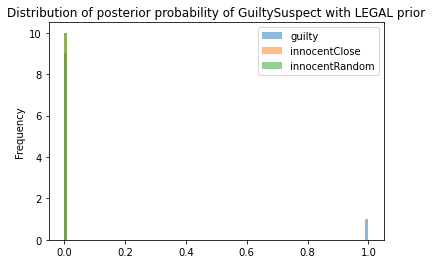

guilty vs innocentClose
0.95 & 0.1 & 0.0 \\
0.96 & 0.1 & 0.0 \\
0.97 & 0.1 & 0.0 \\
0.98 & 0.1 & 0.0 \\
0.99 & 0.1 & 0.0 \\


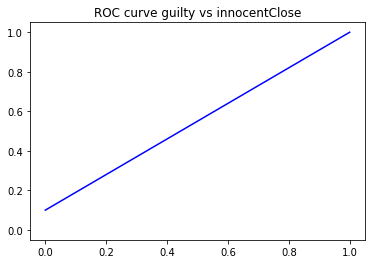

guilty vs innocentRandom
0.95 & 0.1 & 0.0 \\
0.96 & 0.1 & 0.0 \\
0.97 & 0.1 & 0.0 \\
0.98 & 0.1 & 0.0 \\
0.99 & 0.1 & 0.0 \\


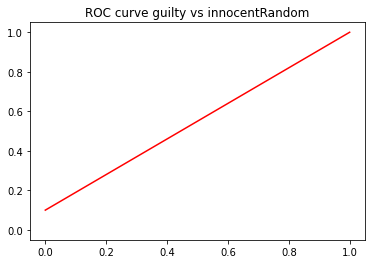

WORLD
1
5
9
correctly classified as guilty (tp):  1
incorrectly classified as innocent (fn):  9
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  10
mcc with threshold as 0.95 for innocentClose is 0.22941573387056174
correctly classified as guilty (tp):  1
incorrectly classified as innocent (fn):  9
incorrectly classified as guilty (fp):  0
correctly classfied as innocent (tn):  10
mcc with threshold as 0.95 for innocentRandom is 0.22941573387056174


<ipython-input-114-8472d9a21fa1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params['Eseen'] = params['Eseen.Eseen']
<ipython-input-114-8472d9a21fa1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["Eseen"] = params["Eseen"].astype('Int64')


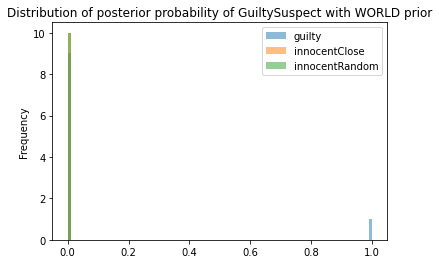

guilty vs innocentClose
0.95 & 0.1 & 0.0 \\
0.96 & 0.1 & 0.0 \\
0.97 & 0.1 & 0.0 \\
0.98 & 0.1 & 0.0 \\
0.99 & 0.1 & 0.0 \\


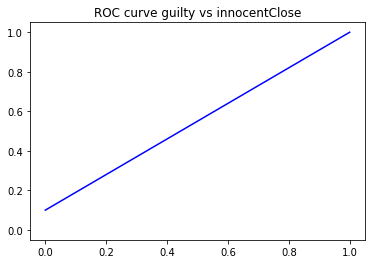

guilty vs innocentRandom
0.95 & 0.1 & 0.0 \\
0.96 & 0.1 & 0.0 \\
0.97 & 0.1 & 0.0 \\
0.98 & 0.1 & 0.0 \\
0.99 & 0.1 & 0.0 \\


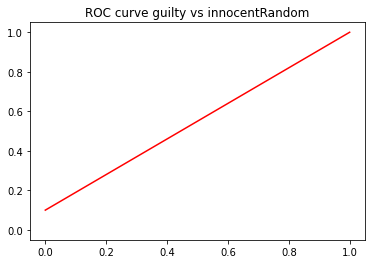

In [127]:
run_analysis(params, "LEGAL", evidence, 1)
run_analysis(params, "WORLD", evidence, 1)

In [ ]:
#run_analysis("OPPORTUNITY", evidence, 1) # true prior 
#run_analysis("OPPORTUNITY", evidence, 2) # seen prior
run_analysis("OPPORTUNITY", evidence, 3) # true prior with small n


In [ ]:
run_analysis("WORLD", evidence, True)
#run_analysis("WORLD", evidence, False)

In [ ]:
run_analysis("LEGAL", evidence, 1)
#run_analysis("LEGAL", evidence, False)

# Further Analysis

Also check:
- what is the dependence on the prior (for which value of the prior of guilty will we get a conviction with the given evidence strength)
- evidence strenght?
- suspect?

In [ ]:
e_h = evidence[0]
e_Nh = evidence[1]

xAxis = []
yAxis = []
for t in range(0, 1000):
    t1= t/1000
    posterior = (e_h*t1)/(e_h*t1 + e_Nh*(1-t1))
    xAxis.append(t1)
    yAxis.append(posterior)
    if posterior > 0.950 and posterior < 0.9501:
        print(t1, posterior)
    elif posterior > 0.990 and posterior < 0.99001:
        print( t1, posterior)
    elif posterior > 0.9990 and posterior < 0.99901:
        print( t1, posterior)
    elif posterior > 0.99990 and posterior < 0.9999025:
        print( t1, posterior)


plot(xAxis, yAxis)
plt.axhline(y=0.95, color="red") 

In [ ]:
new_evidence = (0.999, 0.0001)

for new_evidence in [(0.999, 0.0001), (0.5, 0.5), (0.00001, 0.9999)]:
    print(new_evidence)
    t1 = run_analysis_evidence_strength("OPPORTUNITY", new_evidence, TRUE)
    t2 = run_analysis_evidence_strength("WORLD", new_evidence, TRUE)
    t3 = run_analysis_evidence_strength("LEGAL", new_evidence, TRUE)


# Old stuff

In [38]:
params= pd.read_csv("paramsNew.csv")
params

,Unnamed: 0,type,runNumber,n,seen,agent,Eseen.runNumber,Eseen.Eseen,getsmalln,getidsA,...,E,totalAgents,guilty,opp,guiltySeen,oppSeen,guiltySmalln,oppSmalln,guiltySeenSmalln,oppSeenSmalln
0,1,guilty,1,2,2,8,1.0,1.0,1,[8],...,0,200,0.500000,0.010,0.500000,0.010,1.000000,0.500000,1.000000,0.500000
1,2,guilty,2,12,12,8,2.0,1.0,9,[11 109 126 75 54 27 129 116 194 8],...,1,200,0.083333,0.060,0.083333,0.060,0.111111,0.750000,0.111111,0.750000
2,3,guilty,3,3,3,8,3.0,1.0,1,[11 8],...,1,200,0.333333,0.015,0.333333,0.015,1.000000,0.333333,1.000000,0.333333
3,4,guilty,4,23,14,8,4.0,-1.0,1,[8],...,0,200,0.043478,0.115,0.071429,0.070,1.000000,0.043478,1.000000,0.071429
4,5,guilty,5,200,200,8,NaN,NaN,1,[8],...,1,200,0.005000,1.000,0.005000,1.000,1.000000,0.005000,1.000000,0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,innocentRandom,196,52,38,9,196.0,0.0,1,[8],...,0,200,0.019231,0.260,0.026316,0.190,1.000000,0.019231,1.000000,0.026316
596,597,innocentRandom,197,119,92,9,197.0,0.0,2,[11 140 8],...,0,200,0.008403,0.595,0.010870,0.460,0.500000,0.016807,0.500000,0.021739
597,598,innocentRandom,198,138,105,9,198.0,-1.0,1,[8],...,0,200,0.007246,0.690,0.009524,0.525,1.000000,0.007246,1.000000,0.009524
598,599,innocentRandom,199,102,74,9,199.0,-1.0,2,[149 8],...,0,200,0.009804,0.510,0.013514,0.370,0.500000,0.019608,0.500000,0.027027


In [39]:
g1 = 0.46
g0 = 0.05

(p_hasWalletGuilty, p_hasWalletNotGuilty) =  (g1, g0)
    
# load in bayesian network
bn=gum.loadBN('bn200.net')

g1 = p_hasWalletGuilty
g0 = p_hasWalletNotGuilty

bn.cpt("hasWalletSuspect")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
bn.cpt("hasWalletSuspect")[{"guiltySuspect":0}] = [1-g0, g0]

# load in dataset
params= pd.read_csv("paramsNew.csv")
params = params.loc[params["seen"] != 200] # only get with IDs
params = params.reset_index()
dict_outcomes = {"guilty":[],"innocentClose": [], "innocentRandom": []}
params['Eseen'] = params['Eseen.Eseen'].astype('Int64')

opp_column = "opp"
guilt_column = "guilty"

for index, row in params.iterrows():
    print(row['runNumber'])
    P_oppPrior = row[opp_column]
    P_guilty = row[guilt_column]
    print(row['Eseen'])
    print(row['E'])
    bn.cpt("opportunitySuspect")[{}] = [1-P_oppPrior, P_oppPrior]
    bn.cpt("guiltySuspect")[{"opportunitySuspect":1}] = [1-P_guilty, P_guilty]
    print(bn.cpt("opportunitySuspect"))
    print(bn.cpt("guiltySuspect"))
    ev_dict = {"hasWalletSuspect":row['E']}
    if row['Eseen'] != 1 and row['Eseen'] != 0:
        ev_dict["Eopportunity"]:row['Eseen']
    print(ev_dict)
    s = gum.getPosterior(bn, evs=ev_dict, target="guiltySuspect")
    print(s)
    key = row['type']
    x = dict_outcomes[key]
    x.append(s[1])
    dict_outcomes[key] = x

1
1
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9900  | 0.0100  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.5000  | 0.5000  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

2
1
1

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9400  | 0.0600  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9167  | 0.0833  |

{'hasWalletSuspect': 1}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9558  | 0.0442  |

3
1
1

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9850  | 0.0150  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.6667  | 0.3333  |

{'hasWalletSuspect': 1}

  guiltySuspect    |
0        |1      

154
-1
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.7850  | 0.2150  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9767  | 0.0233  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

155
-1
1

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9750  | 0.0250  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.8000  | 0.2000  |

{'hasWalletSuspect': 1}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9558  | 0.0442  |

156
1
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9850  | 0.0150  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.6667  | 0.3333  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        

31
0
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9300  | 0.0700  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9286  | 0.0714  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

32
0
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.6600  | 0.3400  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9853  | 0.0147  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

33
0
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9650  | 0.0350  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.8571  | 0.1429  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1   


132
0
1

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9550  | 0.0450  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.8889  | 0.1111  |

{'hasWalletSuspect': 1}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9558  | 0.0442  |

133
0
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.9200  | 0.0800  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9375  | 0.0625  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

134
0
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.2150  | 0.7850  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9936  | 0.0064  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |


37
-1
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.5600  | 0.4400  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9886  | 0.0114  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

38
-1
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.2000  | 0.8000  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9938  | 0.0063  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

39
-1
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.8750  | 0.1250  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9600  | 0.0400  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |

0
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.1100  | 0.8900  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9944  | 0.0056  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

145
-1
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.0900  | 0.9100  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9945  | 0.0055  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1        |
---------|---------|
 0.9972  | 0.0028  |

146
0
0

  opportunitySuspec|
0        |1        |
---------|---------|
 0.2750  | 0.7250  |


      ||  guiltySuspect    |
opport||0        |1        |
------||---------|---------|
0     || 1.0000  | 0.0000  |
1     || 0.9931  | 0.0069  |

{'hasWalletSuspect': 0}

  guiltySuspect    |
0        |1   

In [27]:
    
    print(n)
    # create image of plot
    t = f"Distribution of posterior probability of GuiltySuspect with {prior_method} prior"
    ax = n.plot.hist(bins=100, alpha=0.5, 
                 title=t)
    
    # create roc curve
    FPR_collected, TPR_collected = ROC_curve(n, "innocentClose")
    plot(FPR_collected, TPR_collected, "*")
    
    # create roc curve
    FPR_collected, TPR_collected = ROC_curve(n, "innocentRandom")
    plot(FPR_collected, TPR_collected, "*")

NameError: name 'n' is not defined

In [186]:
params= pd.read_csv("paramsNew.csv")
params = params.loc[params["seen"] != 200] # only get with IDs
params = params.reset_index()
dict_outcomes = {"guilty":[],"innocentClose": [], "innocentRandom": []}
# outside parameters
# params for evidence
g1 = 0.9
g0 = 0.01
bn.cpt("hasWalletSuspect")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
bn.cpt("hasWalletSuspect")[{"guiltySuspect":0}] = [1-g0, g0]

# number of runs
RUN_NUM = 50


for index, row in params.iterrows():
    P_oppPrior = row['oppADJ']
    P_guilty = row['guilty']
    bn.cpt("opportunitySuspect")[{}] = [1-P_oppPrior, P_oppPrior]
    bn.cpt("guiltySuspect")[{"opportunitySuspect":1}] = [1-P_guilty, P_guilty]
    #"hasWalletSuspect":row['E']
    s = gum.getPosterior(bn, evs={"Eopportunity":1}, target="guiltySuspect")
    s = gum.getPosterior(bn, evs={"Eopportunity":1, "hasWalletSuspect":row['E']}, target="guiltySuspect")

    key = row['type']
    x = dict_outcomes[key]
    x.append(s[1])
    dict_outcomes[key] = x

for type_suspect in ["guilty", "innocentClose", "innocentRandom"]:
    while len(dict_outcomes[type_suspect]) < RUN_NUM:
        dict_outcomes[type_suspect].append(0)
    
n = pd.DataFrame.from_dict(dict_outcomes)


array([<Axes: title={'center': 'guilty'}, ylabel='Frequency'>,
       <Axes: title={'center': 'innocentClose'}, ylabel='Frequency'>,
       <Axes: title={'center': 'innocentRandom'}, ylabel='Frequency'>],
      dtype=object)

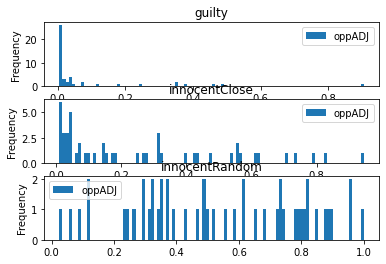

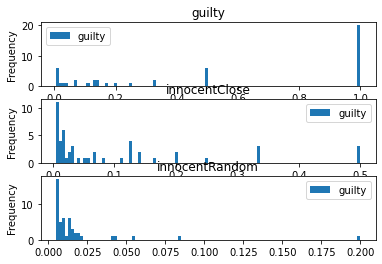

In [187]:
p1 = params.loc[params["seen"] != 200]
p1.plot.hist(column=["oppADJ"], bins=100, by="type")
p1.plot.hist(column=["guilty"], bins=100, by="type")

'The opportunity prior separates guilty from innocent suspects'

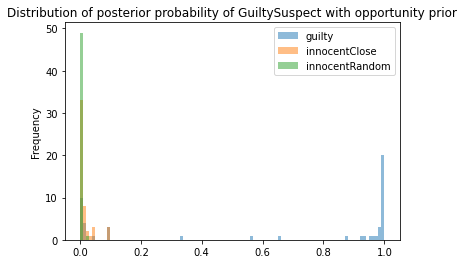

In [188]:
t = "Distribution of posterior probability of GuiltySuspect with opportunity prior"
ax = n.plot.hist(bins=100, alpha=0.5, 
                 title=t)
plt.savefig("posteriorOpp.png")


"The opportunity prior separates guilty from innocent suspects"

In [190]:
ct = n.copy()
t = 0.01
ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
ct["innocentRandom"] = [1 if x >= t else 0 for x in ct["innocentRandom"]]

ct
print("innocent random")

print("correctly classified as guilty (tp): ", ct['guilty'].value_counts()[1])
print("incorrectly classified as innocent (fn): ",ct['guilty'].value_counts()[0])
print("incorrectly classified as guilty (fp): ", ct['innocentRandom'].value_counts()[1])
print("correctly classfied as innocent (tn): ", ct['innocentRandom'].value_counts()[0])

ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
ct["innocentClose"] = [1 if x >= t else 0 for x in ct["innocentClose"]]

ct
print("innocent close")

print("correctly classified as guilty (tp): ", ct['guilty'].value_counts()[1])
print("incorrectly classified as innocent (fn): ",ct['guilty'].value_counts()[0])
print("incorrectly classified as guilty (fp): ", ct['innocentClose'].value_counts()[1])
print("correctly classfied as innocent (tn): ", ct['innocentClose'].value_counts()[0])

innocent random
correctly classified as guilty (tp):  40
incorrectly classified as innocent (fn):  10
incorrectly classified as guilty (fp):  1
correctly classfied as innocent (tn):  49
innocent close
correctly classified as guilty (tp):  40
incorrectly classified as innocent (fn):  10
incorrectly classified as guilty (fp):  17
correctly classfied as innocent (tn):  33


0.0 & 1.0 & 1.0 \\
0.01 & 0.8 & 0.34 \\
0.02 & 0.72 & 0.18 \\
0.03 & 0.72 & 0.14 \\
0.04 & 0.72 & 0.12 \\
0.05 & 0.7 & 0.06 \\
0.06 & 0.7 & 0.06 \\
0.07 & 0.7 & 0.06 \\
0.08 & 0.7 & 0.06 \\
0.09 & 0.7 & 0.06 \\
0.1 & 0.64 & 0.0 \\
0.11 & 0.64 & 0.0 \\
0.12 & 0.64 & 0.0 \\
0.13 & 0.64 & 0.0 \\
0.14 & 0.64 & 0.0 \\
0.15 & 0.64 & 0.0 \\
0.16 & 0.64 & 0.0 \\
0.17 & 0.64 & 0.0 \\
0.18 & 0.64 & 0.0 \\
0.19 & 0.64 & 0.0 \\
0.2 & 0.64 & 0.0 \\
0.21 & 0.64 & 0.0 \\
0.22 & 0.64 & 0.0 \\
0.23 & 0.64 & 0.0 \\
0.24 & 0.64 & 0.0 \\
0.25 & 0.64 & 0.0 \\
0.26 & 0.64 & 0.0 \\
0.27 & 0.64 & 0.0 \\
0.28 & 0.64 & 0.0 \\
0.29 & 0.64 & 0.0 \\
0.3 & 0.64 & 0.0 \\
0.31 & 0.64 & 0.0 \\
0.32 & 0.64 & 0.0 \\
0.33 & 0.64 & 0.0 \\
0.34 & 0.62 & 0.0 \\
0.35 & 0.62 & 0.0 \\
0.36 & 0.62 & 0.0 \\
0.37 & 0.62 & 0.0 \\
0.38 & 0.62 & 0.0 \\
0.39 & 0.62 & 0.0 \\
0.4 & 0.62 & 0.0 \\
0.41 & 0.62 & 0.0 \\
0.42 & 0.62 & 0.0 \\
0.43 & 0.62 & 0.0 \\
0.44 & 0.62 & 0.0 \\
0.45 & 0.62 & 0.0 \\
0.46 & 0.62 & 0.0 \\
0.47 & 0.62 & 0.

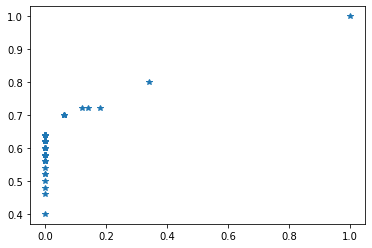

In [191]:
TPR_collected = []
FPR_collected = []
for t in range(0, 100):
    ct = n.copy()

    t = t/100
    ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
    ct["innocentClose"] = [1 if x >= t else 0 for x in ct["innocentClose"]]

    tp =  ct['guilty'].sum()
    fn = len(ct['guilty']) - tp
    fp =  ct['innocentClose'].sum()
    tn =  len(ct['innocentClose'])-fp
    print(f"{t} & {tp/RUN_NUM} & {fp/RUN_NUM} \\\\") # divide by total
    tpr = tp/(tp + fn) # correctly predicted positives vs all actually positives 
    fpr = fp/(fp + tn) # incorrectly predicted positives vs all actually negatives
    TPR_collected.append(tpr)
    FPR_collected.append(fpr)
plot(FPR_collected, TPR_collected, "*")
plt.savefig("ROCOpp.png")


0.0 & 1.0 & 1.0 \\
0.01 & 0.8 & 0.02 \\
0.02 & 0.72 & 0.02 \\
0.03 & 0.72 & 0.0 \\
0.04 & 0.72 & 0.0 \\
0.05 & 0.7 & 0.0 \\
0.06 & 0.7 & 0.0 \\
0.07 & 0.7 & 0.0 \\
0.08 & 0.7 & 0.0 \\
0.09 & 0.7 & 0.0 \\
0.1 & 0.64 & 0.0 \\
0.11 & 0.64 & 0.0 \\
0.12 & 0.64 & 0.0 \\
0.13 & 0.64 & 0.0 \\
0.14 & 0.64 & 0.0 \\
0.15 & 0.64 & 0.0 \\
0.16 & 0.64 & 0.0 \\
0.17 & 0.64 & 0.0 \\
0.18 & 0.64 & 0.0 \\
0.19 & 0.64 & 0.0 \\
0.2 & 0.64 & 0.0 \\
0.21 & 0.64 & 0.0 \\
0.22 & 0.64 & 0.0 \\
0.23 & 0.64 & 0.0 \\
0.24 & 0.64 & 0.0 \\
0.25 & 0.64 & 0.0 \\
0.26 & 0.64 & 0.0 \\
0.27 & 0.64 & 0.0 \\
0.28 & 0.64 & 0.0 \\
0.29 & 0.64 & 0.0 \\
0.3 & 0.64 & 0.0 \\
0.31 & 0.64 & 0.0 \\
0.32 & 0.64 & 0.0 \\
0.33 & 0.64 & 0.0 \\
0.34 & 0.62 & 0.0 \\
0.35 & 0.62 & 0.0 \\
0.36 & 0.62 & 0.0 \\
0.37 & 0.62 & 0.0 \\
0.38 & 0.62 & 0.0 \\
0.39 & 0.62 & 0.0 \\
0.4 & 0.62 & 0.0 \\
0.41 & 0.62 & 0.0 \\
0.42 & 0.62 & 0.0 \\
0.43 & 0.62 & 0.0 \\
0.44 & 0.62 & 0.0 \\
0.45 & 0.62 & 0.0 \\
0.46 & 0.62 & 0.0 \\
0.47 & 0.62 & 0.0 \\
0.

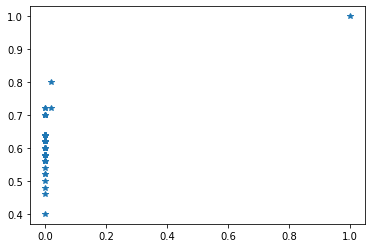

In [192]:
TPR_collected = []
FPR_collected = []
for t in range(0, 100):
    ct = n.copy()

    t = t/100
    ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
    ct["innocentRandom"] = [1 if x >= t else 0 for x in ct["innocentRandom"]]

    tp =  ct['guilty'].sum()
    fn = len(ct['guilty']) - tp
    fp =  ct['innocentRandom'].sum()
    tn =  len(ct['innocentRandom'])-fp
    print(f"{t} & {tp/50} & {fp/50} \\\\") # divide by total
    tpr = tp/(tp + fn) # correctly predicted positives vs all actually positives 
    fpr = fp/(fp + tn) # incorrectly predicted positives vs all actually negatives
    TPR_collected.append(tpr)
    FPR_collected.append(fpr)
plot(FPR_collected, TPR_collected, "*")
plt.savefig("ROCOppRandom.png")

'The opportunity prior separates guilty from innocent suspects'

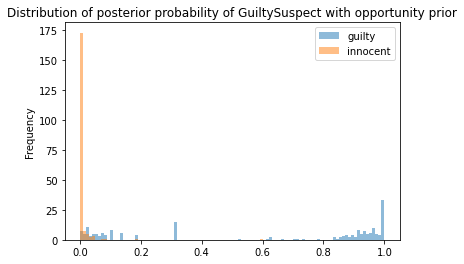

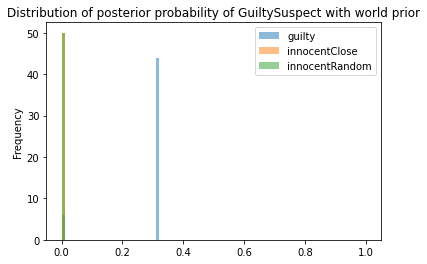

In [183]:
bn_f = 'bn200.net'
bn=gum.loadBN(bn_f)

params= pd.read_csv("paramsNew.csv")
params = params.loc[params["seen"] != 200] # only get with IDs
params = params.reset_index()

dict_outcomes = {"guilty":[], "innocentClose": [], "innocentRandom":[]}

bn.cpt("hasWalletSuspect")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
bn.cpt("hasWalletSuspect")[{"guiltySuspect":0}] = [1-g0, g0]
bn.cpt("guiltySuspect")[{"opportunitySuspect":1}] = [1-0.005, 0.005]

for index, row in params.iterrows():
    s = gum.getPosterior(bn, evs={"Eopportunity":1, "hasWalletSuspect":row['E']}, target="guiltySuspect")
    key = row['type']
    x = dict_outcomes[key]
    x.append(s[1])
    dict_outcomes[key] = x
    
for type_suspect in ["guilty", "innocentClose", "innocentRandom"]:
    while len(dict_outcomes[type_suspect]) < RUN_NUM:
        dict_outcomes[type_suspect].append(0)
    
n = pd.DataFrame.from_dict(dict_outcomes)
t = "Distribution of posterior probability of GuiltySuspect with world prior"
ax = n.plot.hist(bins=100, alpha=0.5, range=[0, 1],
                 title=t)
plt.savefig("posterior200.png")



In [184]:
TPR_collected = []
FPR_collected = []
for t in range(0, 100):
    ct = n.copy()

    t = t/100
    ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
    ct["innocent"] = [1 if x >= t else 0 for x in ct["innocent"]]

    tp =  ct['guilty'].sum()
    fn = len(ct['guilty']) - tp
    fp =  ct['innocent'].sum()
    tn =  len(ct['innocent'])-fp
    print(f"{t} & {tp/200} & {fp/200} \\\\") # divide by total
    tpr = tp/(tp + fn) # correctly predicted positives vs all actually positives 
    fpr = fp/(fp + tn) # incorrectly predicted positives vs all actually negatives
    TPR_collected.append(tpr)
    FPR_collected.append(fpr)
plot(FPR_collected, TPR_collected)
plt.savefig("ROC200.png")

KeyError: 'innocent'

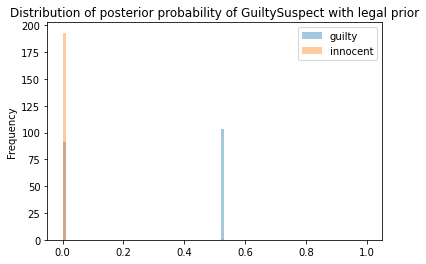

In [56]:
bn_f = 'bn100.net'
bn=gum.loadBN(bn_f)

params= pd.read_csv("params")
params = params.reset_index()
dict_outcomes = {"guilty":[], "innocent": []}


bn.cpt("hasWalletSuspect")[{"guiltySuspect":1}] = [1-g1, g1] # new in this case
bn.cpt("hasWalletSuspect")[{"guiltySuspect":0}] = [1-g0, g0]
bn.cpt("guiltySuspect")[{"opportunitySuspect":1}] = [1-0.01, 0.01]


for index, row in params.iterrows():
    s = gum.getPosterior(bn, evs={"Eopportunity":1, "hasWalletSuspect":row['E']}, target="guiltySuspect")
    key = row['suspectType']
    x = dict_outcomes[key]
    x.append(s[1])
    dict_outcomes[key] = x
    
while len(dict_outcomes["guilty"]) < len(dict_outcomes["innocent"]):
    dict_outcomes["guilty"].append(0)
    
n = pd.DataFrame.from_dict(dict_outcomes)
t = "Distribution of posterior probability of GuiltySuspect with legal prior"
ax = n.plot.hist(bins=100, alpha=0.4, range=[0, 1],
                 title=t)

plt.savefig("posterior100.png")


0.0 & 0.97 & 0.97 \\
0.01 & 0.515 & 0.005 \\
0.02 & 0.515 & 0.005 \\
0.03 & 0.515 & 0.005 \\
0.04 & 0.515 & 0.005 \\
0.05 & 0.515 & 0.005 \\
0.06 & 0.515 & 0.005 \\
0.07 & 0.515 & 0.005 \\
0.08 & 0.515 & 0.005 \\
0.09 & 0.515 & 0.005 \\
0.1 & 0.515 & 0.005 \\
0.11 & 0.515 & 0.005 \\
0.12 & 0.515 & 0.005 \\
0.13 & 0.515 & 0.005 \\
0.14 & 0.515 & 0.005 \\
0.15 & 0.515 & 0.005 \\
0.16 & 0.515 & 0.005 \\
0.17 & 0.515 & 0.005 \\
0.18 & 0.515 & 0.005 \\
0.19 & 0.515 & 0.005 \\
0.2 & 0.515 & 0.005 \\
0.21 & 0.515 & 0.005 \\
0.22 & 0.515 & 0.005 \\
0.23 & 0.515 & 0.005 \\
0.24 & 0.515 & 0.005 \\
0.25 & 0.515 & 0.005 \\
0.26 & 0.515 & 0.005 \\
0.27 & 0.515 & 0.005 \\
0.28 & 0.515 & 0.005 \\
0.29 & 0.515 & 0.005 \\
0.3 & 0.515 & 0.005 \\
0.31 & 0.515 & 0.005 \\
0.32 & 0.515 & 0.005 \\
0.33 & 0.515 & 0.005 \\
0.34 & 0.515 & 0.005 \\
0.35 & 0.515 & 0.005 \\
0.36 & 0.515 & 0.005 \\
0.37 & 0.515 & 0.005 \\
0.38 & 0.515 & 0.005 \\
0.39 & 0.515 & 0.005 \\
0.4 & 0.515 & 0.005 \\
0.41 & 0.515 & 0.005 \\

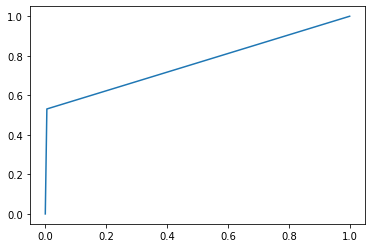

In [57]:
TPR_collected = []
FPR_collected = []
for t in range(0, 100):
    ct = n.copy()

    t = t/100
    ct["guilty"] = [1 if x >= t else 0 for x in ct["guilty"]]
    ct["innocent"] = [1 if x >= t else 0 for x in ct["innocent"]]

    tp =  ct['guilty'].sum()
    fn = len(ct['guilty']) - tp
    fp =  ct['innocent'].sum()
    tn =  len(ct['innocent'])-fp
    print(f"{t} & {tp/200} & {fp/200} \\\\") # divide by total
    tpr = tp/(tp + fn) # correctly predicted positives vs all actually positives 
    fpr = fp/(fp + tn) # incorrectly predicted positives vs all actually negatives
    TPR_collected.append(tpr)
    FPR_collected.append(fpr)
plot(FPR_collected, TPR_collected)
plt.savefig("ROC100.png")
